<div class="alert alert-block alert-danger">
    <p style="text-align: center;">
        <font size="5">
            <strong>
                Projet n°7 - Implémenter un modèle de scoring
            </strong>
        </font>
    </p>
</div>

<div class="alert alert-block alert-info">
    <p style="text-align: center;">
        <font size="4">
            <strong>
                Notebook exploration <br>             
            </strong>
        </font>
    </p>
</div>

# Import des packages


In [1]:
# Installation du package

# pip install lightgbm

In [1]:
import numpy as np
import pandas as pd
import gc
import re
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import des données

In [3]:
# df = pd.read_csv('Données/application_train.csv')
# test_df = pd.read_csv('Données/application_test.csv')
# print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
# df = pd.concat([df,test_df]).reset_index()

In [4]:
# df.shape, test_df.shape

In [5]:
# pd.concat([df,test_df])

In [4]:
# %% [code]
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)



@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


In [5]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('Données/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('Données/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = pd.concat([df,test_df]).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('Données/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('Données/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('Données/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('Données/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('Données/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('Données/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    df = df.rename(columns = lambda x:x.upper())
    for i in df.columns:
        if df[i].dtypes=='object':
            df[i]=df[i].astype('bool')
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc')

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv('output_kfolds', index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')


def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df, num_folds= 3, stratified= False, debug= debug)

## débug du kernel

In [8]:
# temp=main_temp(debug=True)

In [9]:
# temp.loc[:,temp.dtypes.values=='object']

In [10]:
# for i in temp.columns:
#     if temp[i].dtypes=='object':
#         temp[i]=temp[i].astype('bool')

In [11]:
# temp.dtypes.value_counts()

In [12]:
# temp['CC_NAME_CONTRACT_STATUS_Active_MIN'].dtypes

In [13]:
# kfold_lightgbm(temp, 2, stratified = False, debug= True)

In [14]:
# def main(debug = True):
#     num_rows = 10000 if debug else None
#     df = application_train_test(num_rows)
#     with timer("Process bureau and bureau_balance"):
#         bureau = bureau_and_balance(num_rows)
#         print("Bureau df shape:", bureau.shape)
#         df = df.join(bureau, how='left', on='SK_ID_CURR')
#         del bureau
#         gc.collect()
#     with timer("Process previous_applications"):
#         prev = previous_applications(num_rows)
#         print("Previous applications df shape:", prev.shape)
#         df = df.join(prev, how='left', on='SK_ID_CURR')
#         del prev
#         gc.collect()
#     with timer("Process POS-CASH balance"):
#         pos = pos_cash(num_rows)
#         print("Pos-cash balance df shape:", pos.shape)
#         df = df.join(pos, how='left', on='SK_ID_CURR')
#         del pos
#         gc.collect()
#     with timer("Process installments payments"):
#         ins = installments_payments(num_rows)
#         print("Installments payments df shape:", ins.shape)
#         df = df.join(ins, how='left', on='SK_ID_CURR')
#         del ins
#         gc.collect()
#     with timer("Process credit card balance"):
#         cc = credit_card_balance(num_rows)
#         print("Credit card balance df shape:", cc.shape)
#         df = df.join(cc, how='left', on='SK_ID_CURR')
#         del cc
#         gc.collect()
#     with timer("Run LightGBM with kfold"):
#         feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug=True)

In [15]:
# dict1={'CC_NAME_CONTRACT_STATUS_Active_MIN': object, 'CC_NAME_CONTRACT_STATUS_Active_MAX': object,
# ' CC_NAME_CONTRACT_STATUS_Approved_MIN': object, 'CC_NAME_CONTRACT_STATUS_Approved_MAX': object, 'CC_NAME_CONTRACT_STATUS_Completed_MIN': object,
#  'CC_NAME_CONTRACT_STATUS_Completed_MAX': object, 'CC_NAME_CONTRACT_STATUS_Demand_MIN': object, 'CC_NAME_CONTRACT_STATUS_Demand_MAX': object,
#   'CC_NAME_CONTRACT_STATUS_Refused_MIN': object, 'CC_NAME_CONTRACT_STATUS_Refused_MAX': object, 'CC_NAME_CONTRACT_STATUS_Sent proposal_MIN': object,
#    'CC_NAME_CONTRACT_STATUS_Sent proposal_MAX': object, 'CC_NAME_CONTRACT_STATUS_Signed_MIN': object, 'CC_NAME_CONTRACT_STATUS_Signed_MAX': object,
#     'CC_NAME_CONTRACT_STATUS_nan_MIN': object, 'CC_NAME_CONTRACT_STATUS_nan_MAX': object}

In [16]:
# dict1.values(),dict1.keys()

In [17]:
# application_train_test(5000)

In [18]:

# def has_special_characters(s):
#     # Define a regular expression pattern to match JSON special characters
#     special_char_pattern = re.compile(r'["\\/\\b\\f\\n\\r\\t]')
    
#     # Search for special characters in the string
#     return bool(special_char_pattern.search(s)),special_char_pattern.search(s)

# # Check each string for special characters
# for s in temp.columns:
#     if has_special_characters(s)[0]:
#         print(f"'{s}' contains JSON special characters.",has_special_characters(s))
    

In [19]:
# feats.index('NAME_CONTRACT_TYPE_Cash_loans')

In [20]:
# feats[107][27]

In [21]:
# temp = temp.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [22]:
# # Check each string for special characters
# for s in temp.columns:
#     if has_special_characters(s)[0]:
#         print(f"'{s}' contains JSON special characters.",has_special_characters(s))

In [23]:
# temp = temp.rename(columns = lambda x:x.upper())

In [24]:
# temp.head()

In [25]:
# # Check each string for special characters
# for s in temp.columns:
#     if has_special_characters(s)[0]:
#         print(f"'{s}' contains JSON special characters.",has_special_characters(s))

Solution stackoverflow:  
rename les colonnes avec df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


In [26]:
# Liste des erreurs/ modifs par rapport au kernal de base:
# modif des chemins d'import
# Append => concat dans application test_train
# enlever verbose dans le clf.fit
# enlever early_stopping_rounds
# ajouter le force des types
# ajouter import re
# ajouter fonctions de rename des colonnes pour retirer les caractères json et forcer en upper pour que lightgbm fonctionne correctement

## Reprise des traitements

In [27]:
# # 15 min30 pour fold =2
# kfold_lightgbm(application_train_test(), 2, stratified = False)

In [6]:
#50 min avec 2 folds
main()

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 21s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 24s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 13s
Installments payments df shape: (339587, 26)
Process installments payments - done in 26s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 15s
Starting LightGBM. Train shape: (307507, 798), test shape: (48744, 798)
Fold  1 AUC : 0.772632
Fold  2 AUC : 0.774222
Fold  3 AUC : 0.776929
Full AUC score 0.774532


type: name 'submission_file_name' is not defined

In [7]:
feature_importance_df

type: name 'feature_importance_df' is not defined

Sauvegarde du print de sortie avec 2 folds <br>
Train samples: 307511, test samples: 48744  <br>
Bureau df shape: (305811, 116)  <br>
Process bureau and bureau_balance - done in 28s <br>
Previous applications df shape: (338857, 249) <br>
Process previous_applications - done in 40s <br>
Pos-cash balance df shape: (337252, 18) <br>
Process POS-CASH balance - done in 18s <br>
Installments payments df shape: (339587, 26) <br>
Process installments payments - done in 35s <br>
Credit card balance df shape: (103558, 141) <br>
Process credit card balance - done in 23s <br>
Starting LightGBM. Train shape: (307507, 798), test shape: (48744, 798) <br>
Fold  1 AUC : 0.766699 <br>
Fold  2 AUC : 0.767250 <br>
Full AUC score 0.766974 <br>
Run LightGBM with kfold - done in 2798s <br>
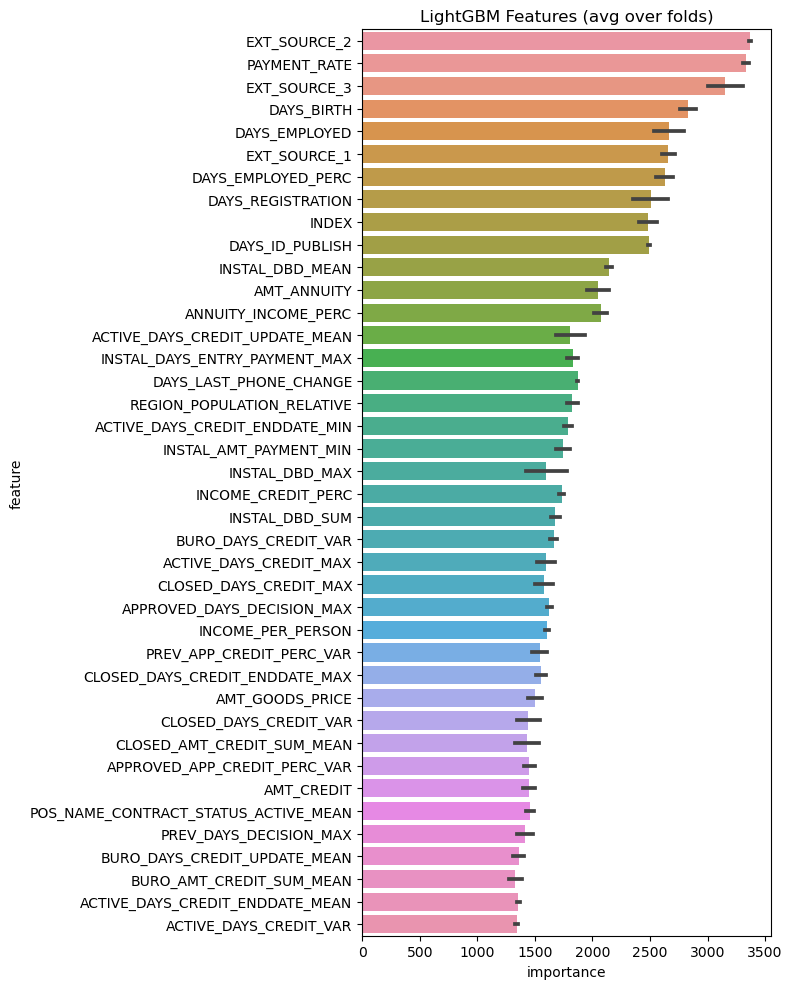

## Création des fichiers des df après pré-process

In [29]:
feat_important=['EXT_SOURCE_2','PAYMENT_RATE','EXT_SOURCE_3','DAYS_BIRTH','DAYS_EMPLOYED','EXT_SOURCE_1','DAYS_EMPLOYED_PERC','DAYS_REGISTRATION','INDEX','DAYS_ID_PUBLISH',
'INSTAL_DBD_MEAN','AMT_ANNUITY','ANNUITY_INCOME_PERC','ACTIVE_DAYS_CREDIT_UPDATE_MEAN','INSTAL_DAYS_ENTRY_PAYMENT_MAX','DAYS_LAST_PHONE_CHANGE','REGION_POPULATION_RELATIVE','ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
'CLOSED_DAYS_CREDIT_MAX','APPROVED_DAYS_DECISION_MAX','INCOME_PER_PERSON','PREV_APP_CREDIT_PERC_VAR','CLOSED_DAYS_CREDIT_ENDDATE_MAX','AMT_GOODS_PRICE','CLOSED_DAYS_CREDIT_VAR','CLOSED_AMT_CREDIT_SUM_MEAN',
'APPROVED_APP_CREDIT_PERC_VAR','AMT_CREDIT','POS_NAME_CONTRACT_STATUS_ACTIVE_MEAN','PREV_DAYS_DECISION_MAX','BURO_DAYS_CREDIT_UPDATE_MEAN','BURO_AMT_CREDIT_SUM_MEAN','ACTIVE_DAYS_CREDIT_ENDDATE_MEAN','ACTIVE_DAYS_CREDIT_VAR']

In [30]:
# df_test_train
# df_bureau_balance
# df_prev_app
# df_pos_cash
# df_payments
# df_card_balance


In [31]:
def visu_df(dataframe):
    return display('Shape',dataframe.shape,'Describe',dataframe.describe(),'Head',dataframe.head())

In [32]:
df_test_train=application_train_test(num_rows = None, nan_as_category = False).copy()

Train samples: 307511, test samples: 48744


In [33]:
temp=df_test_train.set_index('SK_ID_CURR')
temp.index.rename('ID',inplace=True)
temp.insert(1,'SK_ID_CURR',temp.index)
temp.head()
df_test_train=temp.copy()

In [34]:
visu_df(df_test_train)

'Shape'

(356251, 248)

'Describe'

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
count,356251.000000,356251.000000,307507.00000,356251.000000,356251.000000,356251.000000,356251.000000,3.562510e+05,3.562510e+05,356215.000000,...,308683.000000,308683.000000,308683.000000,308683.000000,308683.000000,291603.000000,356251.000000,3.562490e+05,356215.000000,356215.000000
mean,136052.869904,278128.870078,0.08073,0.660001,0.339699,0.306764,0.414312,1.701159e+05,5.877695e+05,27425.644390,...,0.006282,0.029995,0.231691,0.304400,1.911544,0.157797,0.411925,9.378647e+04,0.181212,0.055463
std,93841.582375,102842.068890,0.27242,0.473709,0.473608,0.461151,0.720376,2.235080e+05,3.986253e+05,14732.860946,...,0.104251,0.191375,0.855940,0.786919,1.865330,0.133449,0.496408,9.810132e+04,0.094701,0.023206
min,0.000000,100001.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.011801,2.812500e+03,0.000224,0.022073
25%,44532.000000,189065.500000,0.00000,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16731.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.056954,0.200000,4.950000e+04,0.114950,0.038080
50%,129384.000000,278129.000000,0.00000,1.000000,0.000000,0.000000,0.000000,1.530000e+05,5.002110e+05,25078.500000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.120073,0.316570,7.500000e+04,0.163182,0.050000
75%,218447.500000,367192.500000,0.00000,1.000000,1.000000,1.000000,1.000000,2.025000e+05,7.975575e+05,34960.500000,...,0.000000,0.000000,0.000000,0.000000,3.000000,0.220597,0.500000,1.125000e+05,0.229156,0.067066
max,307510.000000,456255.000000,1.00000,1.000000,1.000000,1.000000,20.000000,1.170000e+08,4.050000e+06,258025.500000,...,9.000000,8.000000,27.000000,261.000000,25.000000,0.728811,208.003328,3.900000e+07,2.024714,0.124430


'Head'

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
ID,,,,,,,,,,,,,,,,,,,,,
100002,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,False,True,False,True,False,0.067329,0.498036,202500.0,0.121978,0.060749
100003,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,False,False,False,True,False,0.070862,0.208736,135000.0,0.132217,0.027598
100004,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,False,False,False,False,False,0.011814,0.500000,67500.0,0.100000,0.050000
100006,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,False,False,False,False,False,0.159905,0.431748,67500.0,0.219900,0.094941
100007,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,False,False,False,False,False,0.152418,0.236842,121500.0,0.179963,0.042623


In [35]:
df_bureau_balance=bureau_and_balance(num_rows = None, nan_as_category = True).copy()

In [36]:
visu_df(df_bureau_balance)

'Shape'

(305811, 116)

'Describe'

,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,...,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_AMT_ANNUITY_MAX,CLOSED_AMT_ANNUITY_MEAN,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_MIN_MIN,CLOSED_MONTHS_BALANCE_MAX_MAX,CLOSED_MONTHS_BALANCE_SIZE_MEAN,CLOSED_MONTHS_BALANCE_SIZE_SUM
count,305811.000000,305811.000000,305811.000000,2.642910e+05,303226.000000,303226.000000,303226.000000,305811.000000,305811.000000,305811.000000,...,267925.000000,2.299410e+05,2.679250e+05,9.519700e+04,9.519700e+04,267925.000000,118495.000000,118495.000000,118495.000000,267925.000000
mean,-1764.362845,-490.942608,-1083.802103,4.856008e+05,-1029.705151,4508.643464,662.420814,-542.965748,4.436629,0.965926,...,3.329939,9.946875e+02,3.309811e+03,2.961504e+04,1.360898e+04,0.015012,-60.204161,-2.460475,37.116217,69.093414
std,859.260807,533.529324,558.441124,4.627030e+05,2621.100512,9422.717152,3282.359178,446.427113,85.573591,24.957209,...,1234.759685,1.215996e+04,3.683350e+04,6.732444e+05,2.376805e+05,0.144439,25.717925,9.682761,19.664782,129.503126
min,-2922.000000,-2922.000000,-2922.000000,0.000000e+00,-42060.000000,-41875.000000,-41875.000000,-41890.000000,0.000000,0.000000,...,0.000000,-8.687587e+03,-3.475035e+04,0.000000e+00,0.000000e+00,0.000000,-96.000000,-94.000000,1.000000,0.000000
25%,-2583.000000,-623.000000,-1431.000000,1.257143e+05,-2128.000000,126.000000,-697.525000,-773.696154,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,-85.000000,0.000000,22.000000,0.000000
50%,-1822.000000,-305.000000,-1052.500000,3.803969e+05,-1272.000000,912.000000,-131.788889,-479.300000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,-62.000000,0.000000,35.000000,0.000000
75%,-1045.000000,-149.000000,-670.369318,7.130844e+05,-458.000000,1692.000000,613.000000,-209.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,1.562013e+04,9.047864e+03,0.000000,-39.000000,0.000000,49.800000,89.000000
max,0.000000,0.000000,0.000000,4.173160e+06,31198.000000,31199.000000,31198.000000,14.000000,2792.000000,2776.000000,...,617070.000000,1.125000e+06,2.250000e+06,1.184534e+08,5.456266e+07,6.000000,0.000000,0.000000,97.000000,2609.000000


'Head'

,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,...,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_AMT_ANNUITY_MAX,CLOSED_AMT_ANNUITY_MEAN,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_MIN_MIN,CLOSED_MONTHS_BALANCE_MAX_MAX,CLOSED_MONTHS_BALANCE_SIZE_MEAN,CLOSED_MONTHS_BALANCE_SIZE_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-1572,-49,-735.000000,240043.666667,-1329.0,1778.0,82.428571,-93.142857,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-51.0,0.0,35.0,140.0
100002,-1437,-103,-874.000000,186150.000000,-1072.0,780.0,-349.000000,-499.875000,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-47.0,0.0,15.0,90.0
100003,-2586,-606,-1400.750000,827783.583333,-2434.0,1216.0,-544.500000,-816.000000,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
100004,-1326,-408,-867.000000,421362.000000,-595.0,-382.0,-488.500000,-532.000000,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
100005,-373,-62,-190.666667,26340.333333,-128.0,1324.0,439.333333,-54.333333,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-12.0,0.0,13.0,13.0


In [37]:
df_prev_app=previous_applications(num_rows = None, nan_as_category = True).copy()

In [38]:
visu_df(df_prev_app)

'Shape'

(338857, 249)

'Describe'

,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_APP_CREDIT_PERC_MIN,...,REFUSED_HOUR_APPR_PROCESS_START_MAX,REFUSED_HOUR_APPR_PROCESS_START_MEAN,REFUSED_RATE_DOWN_PAYMENT_MIN,REFUSED_RATE_DOWN_PAYMENT_MAX,REFUSED_RATE_DOWN_PAYMENT_MEAN,REFUSED_DAYS_DECISION_MIN,REFUSED_DAYS_DECISION_MAX,REFUSED_DAYS_DECISION_MEAN,REFUSED_CNT_PAYMENT_MEAN,REFUSED_CNT_PAYMENT_SUM
count,338377.000000,338377.000000,338377.000000,3.388570e+05,3.388570e+05,3.388570e+05,3.388570e+05,3.388570e+05,3.388570e+05,338605.000000,...,118277.000000,118277.000000,52605.000000,52605.000000,52605.000000,118277.000000,118277.000000,118277.000000,108096.000000,118277.000000
mean,7912.938354,23944.281570,14656.028970,4.405501e+04,3.775473e+05,1.544683e+05,4.819918e+04,4.167555e+05,1.703318e+05,0.793707,...,13.288103,12.429229,0.050500,0.072847,0.060898,-984.352123,-724.998267,-846.055465,20.276181,49.005386
std,7603.257835,19264.040276,10093.856491,9.350608e+04,4.219383e+05,1.526145e+05,9.644586e+04,4.574522e+05,1.649810e+05,0.350306,...,3.376286,3.107724,0.088162,0.103926,0.090671,830.032165,740.460607,739.365204,17.564565,78.842269
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-2922.000000,-2922.000000,-2922.000000,0.000000,0.000000
25%,3499.290000,10525.725000,7908.423750,0.000000e+00,9.957150e+04,6.259770e+04,0.000000e+00,1.061505e+05,6.741675e+04,0.814972,...,11.000000,10.166667,0.000000,0.000000,0.000000,-1519.000000,-972.000000,-1202.166667,6.000000,6.000000
50%,5750.775000,18081.270000,12092.197500,1.755000e+04,2.105100e+05,1.068345e+05,2.318850e+04,2.250000e+05,1.181655e+05,0.898449,...,13.000000,12.333333,0.000000,0.000000,0.000000,-642.000000,-403.000000,-551.000000,14.000000,24.000000
75%,9550.260000,31840.875000,18489.159000,5.393250e+04,4.635000e+05,1.916936e+05,5.822550e+04,5.539500e+05,2.164125e+05,1.000000,...,16.000000,14.600000,0.106815,0.108926,0.108909,-325.000000,-218.000000,-294.000000,31.500000,60.000000
max,300425.445000,418058.145000,300425.445000,4.050000e+06,6.905160e+06,4.050000e+06,4.050000e+06,6.905160e+06,4.050000e+06,10.000000,...,23.000000,23.000000,0.907515,0.939195,0.907515,-2.000000,-2.000000,-2.000000,84.000000,1728.000000


'Head'

,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_APP_CREDIT_PERC_MIN,...,REFUSED_HOUR_APPR_PROCESS_START_MAX,REFUSED_HOUR_APPR_PROCESS_START_MEAN,REFUSED_RATE_DOWN_PAYMENT_MIN,REFUSED_RATE_DOWN_PAYMENT_MAX,REFUSED_RATE_DOWN_PAYMENT_MEAN,REFUSED_DAYS_DECISION_MIN,REFUSED_DAYS_DECISION_MAX,REFUSED_DAYS_DECISION_MEAN,REFUSED_CNT_PAYMENT_MEAN,REFUSED_CNT_PAYMENT_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3951.000,3951.000,3951.000,24835.5,24835.5,24835.50,23787.0,23787.0,23787.00,1.044079,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100002,9251.775,9251.775,9251.775,179055.0,179055.0,179055.00,179055.0,179055.0,179055.00,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,6737.310,98356.995,56553.990,68809.5,900000.0,435436.50,68053.5,1035882.0,484191.00,0.868825,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,5357.250,5357.250,5357.250,24282.0,24282.0,24282.00,20106.0,20106.0,20106.00,1.207699,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100005,4813.200,4813.200,4813.200,0.0,44617.5,22308.75,0.0,40153.5,20076.75,1.111173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
df_pos_cash=pos_cash(num_rows = None, nan_as_category = True).copy()

In [40]:
visu_df(df_pos_cash)

'Shape'

(337252, 18)

'Describe'

,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_NAME_CONTRACT_STATUS_XNA_MEAN,POS_NAME_CONTRACT_STATUS_nan_MEAN,POS_COUNT
count,337252.000000,337252.000000,337252.000000,337252.000000,337252.000000,337252.000000,337252.000000,337252.000000,337252.000000,337252.000000,337252.000000,337252.000000,337252.000000,337252.000000,337252.000000,3.372520e+05,337252.0,337252.000000
mean,-12.591605,-31.873263,29.655445,15.294106,4.296271,1.473355,0.225470,0.903948,0.000021,0.000595,0.000003,0.083706,0.000276,0.000839,0.010611,3.672319e-08,0.0,29.655445
std,18.648620,20.081193,24.531971,151.343806,59.717229,32.337266,13.554576,0.075490,0.003075,0.007529,0.000698,0.064431,0.011630,0.010447,0.032589,1.508067e-05,0.0,24.531971
min,-96.000000,-96.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,1.000000
25%,-15.000000,-43.988354,12.000000,0.000000,0.000000,0.000000,0.000000,0.875000,0.000000,0.000000,0.000000,0.048387,0.000000,0.000000,0.000000,0.000000e+00,0.0,12.000000
50%,-4.000000,-28.571429,22.000000,0.000000,0.000000,0.000000,0.000000,0.916667,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000e+00,0.0,22.000000
75%,-2.000000,-15.500000,39.000000,0.000000,0.000000,0.000000,0.000000,0.945946,0.000000,0.000000,0.000000,0.108696,0.000000,0.000000,0.000000,0.000000e+00,0.0,39.000000
max,-1.000000,-1.000000,295.000000,4231.000000,2622.078431,3595.000000,1740.554455,1.000000,0.711340,1.000000,0.333333,1.000000,0.793103,1.000000,1.000000,6.250000e-03,0.0,295.000000


'Head'

,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_NAME_CONTRACT_STATUS_XNA_MEAN,POS_NAME_CONTRACT_STATUS_nan_MEAN,POS_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,
100001,-53,-72.555556,9,7,0.777778,7,0.777778,0.777778,0.0,0.0,0.0,0.222222,0.0,0.0,0.000000,0.0,0.0,9
100002,-1,-10.000000,19,0,0.000000,0,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,19
100003,-18,-43.785714,28,0,0.000000,0,0.000000,0.928571,0.0,0.0,0.0,0.071429,0.0,0.0,0.000000,0.0,0.0,28
100004,-24,-25.500000,4,0,0.000000,0,0.000000,0.750000,0.0,0.0,0.0,0.250000,0.0,0.0,0.000000,0.0,0.0,4
100005,-15,-20.000000,11,0,0.000000,0,0.000000,0.818182,0.0,0.0,0.0,0.090909,0.0,0.0,0.090909,0.0,0.0,11


In [41]:
df_payments=installments_payments(num_rows = None, nan_as_category = True).copy()

In [42]:
visu_df(df_payments)

'Shape'

(339587, 26)

'Describe'

,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
count,339587.000000,339587.000000,339587.000000,339587.000000,339587.000000,339587.000000,339587.000000,3.395780e+05,339559.000000,339568.000000,...,3.395870e+05,3.395870e+05,3.395780e+05,3.395780e+05,3.395780e+05,3.395870e+05,339578.000000,339578.000000,339587.00000,339587.000000
mean,2.303413,17.843637,1.027073,41.417275,37.944235,12.283245,393.405566,inf,1.360340,51.205700,...,1.861577e+04,6.831369e+05,5.282753e+03,1.400438e+05,1.900381e+04,6.904942e+05,-328.433435,-922.095504,-42103.40703,40.064552
std,1.870607,108.273851,8.813836,326.815463,28.862360,9.181630,408.301149,NaN,28.429930,846.431025,...,2.346509e+04,8.933805e+05,1.449867e+04,2.496554e+05,2.523135e+04,9.308977e+05,537.367821,597.181989,56863.13532,41.053343
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.121918e-01,0.333333,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,2.250000e-01,1.890000e-01,0.000000e+00,-3071.000000,-3071.000000,-602499.00000,1.000000
25%,1.000000,0.000000,0.000000,0.000000,23.000000,6.681008,134.000000,1.000000e+00,0.955224,12.000000,...,7.897470e+03,1.366834e+05,4.153500e+01,1.439653e+04,7.582365e+03,1.332007e+05,-387.000000,-1312.043107,-49853.00000,12.000000
50%,2.000000,1.000000,0.035714,1.000000,31.000000,10.125000,267.000000,1.000000e+00,1.000000,24.617193,...,1.272616e+04,3.343952e+05,2.323575e+03,3.703561e+04,1.240398e+04,3.248035e+05,-65.000000,-806.576364,-21233.00000,25.000000
75%,3.000000,9.000000,0.500000,20.000000,43.000000,15.151134,510.000000,1.000000e+00,1.000000,51.000000,...,2.164516e+04,8.577727e+05,7.158724e+03,1.350000e+05,2.164505e+04,8.497309e+05,-26.000000,-433.857143,-6832.00000,51.000000
max,59.000000,2884.000000,1885.386364,82957.000000,3189.000000,295.000000,10529.000000,inf,8482.446155,194505.460372,...,2.504590e+06,3.247978e+07,2.504590e+06,3.771488e+06,2.504590e+06,3.268928e+07,-1.000000,-3.000000,0.00000,372.000000


'Head'

,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,2,11.0,1.571429,11.0,36.0,8.857143,62.0,1.0,1.0,7.0,...,5885.132143,41195.925,3951.000,17397.900,5885.132143,41195.925,-1628.0,-2195.000000,-15365.0,7
100002,2,0.0,0.000000,0.0,31.0,20.421053,388.0,1.0,1.0,19.0,...,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19
100003,2,0.0,0.000000,0.0,14.0,7.160000,179.0,1.0,1.0,25.0,...,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25
100004,2,0.0,0.000000,0.0,11.0,7.666667,23.0,1.0,1.0,3.0,...,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3
100005,2,1.0,0.111111,1.0,37.0,23.666667,213.0,1.0,1.0,9.0,...,6240.205000,56161.845,4813.200,17656.245,6240.205000,56161.845,-470.0,-609.555556,-5486.0,9


In [43]:
df_card_balance=credit_card_balance(num_rows = None, nan_as_category = True).copy()

In [44]:
visu_df(df_card_balance)

'Shape'

(103558, 141)

'Describe'

,CC_MONTHS_BALANCE_MIN,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_MEAN,CC_MONTHS_BALANCE_SUM,CC_MONTHS_BALANCE_VAR,CC_AMT_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_SUM,CC_AMT_BALANCE_VAR,...,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
count,103558.000000,103558.000000,103558.000000,103558.000000,102866.000000,103558.000000,1.035580e+05,103558.000000,1.035580e+05,1.028660e+05,...,103558.000000,103558.000000,102866.000000,103558.000000,103558.000000,102866.000000,103558.0,103558.0,102866.0,103558.000000
mean,-37.534531,-1.518965,-19.505553,-1280.199946,211.898513,10542.130509,1.422979e+05,69973.192455,2.161984e+06,5.626113e+09,...,0.000059,0.004954,0.000060,0.003583,0.106781,0.002955,0.0,0.0,0.0,37.083683
std,33.379821,0.734817,16.666571,1743.939291,289.025923,44311.662362,1.713255e+05,107537.810551,3.269300e+06,1.484490e+10,...,0.000846,0.070209,0.000849,0.031014,1.272522,0.019938,0.0,0.0,0.0,33.483627
min,-96.000000,-12.000000,-50.179775,-9312.000000,0.500000,-420250.185000,0.000000e+00,-2930.232558,-1.260000e+05,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.000000
25%,-75.000000,-2.000000,-38.000000,-2850.000000,9.166667,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,10.000000
50%,-22.000000,-1.000000,-12.000000,-253.000000,42.166667,0.000000,9.610718e+04,24997.602995,7.013641e+05,7.535426e+08,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,22.000000
75%,-11.000000,-1.000000,-6.000000,-65.000000,475.000000,0.000000,1.946125e+05,96997.746023,2.979703e+06,4.480692e+09,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,75.000000
max,-1.000000,-1.000000,-1.000000,-1.000000,880.521515,869873.535000,1.505902e+06,928686.323571,2.998048e+07,3.439325e+11,...,0.024390,1.000000,0.024390,1.000000,62.000000,0.500000,0.0,0.0,0.0,192.000000


'Head'

,CC_MONTHS_BALANCE_MIN,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_MEAN,CC_MONTHS_BALANCE_SUM,CC_MONTHS_BALANCE_VAR,CC_AMT_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_SUM,CC_AMT_BALANCE_VAR,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,-6,-1,-3.5,-21,3.5,0.0,0.00,0.000000,0.000,0.000000e+00,...,False,0.0,0,0.0,False,False,0.0,0,0.0,6
100011,-75,-2,-38.5,-2849,462.5,0.0,189000.00,54482.111149,4031676.225,4.641321e+09,...,False,0.0,0,0.0,False,False,0.0,0,0.0,74
100013,-96,-1,-48.5,-4656,776.0,0.0,161420.22,18159.919219,1743352.245,1.869473e+09,...,False,0.0,0,0.0,False,False,0.0,0,0.0,96
100021,-18,-2,-10.0,-170,25.5,0.0,0.00,0.000000,0.000,0.000000e+00,...,False,0.0,0,0.0,False,False,0.0,0,0.0,17
100023,-11,-4,-7.5,-60,6.0,0.0,0.00,0.000000,0.000,0.000000e+00,...,False,0.0,0,0.0,False,False,0.0,0,0.0,8


## Controle


In [45]:
list_df=[df_test_train,df_prev_app,df_bureau_balance,df_payments,df_pos_cash,df_card_balance]

In [46]:
def Controle(x):
    # DataFrame de contrôles sur les colonnes
    tempo = pd.DataFrame(columns=['nomcol', 'type', 'unique',
                    'unique%','doubl%' ,'manqu', 'manqu%', 'rempli', 'rempli%','skew'])

    tot = x.shape[0]

    tempo['nomcol'] = pd.Series(x.columns) # nom des colonnes

    for i in x.columns:
        j=list(x.columns).index(i)
        
        tempo.at[j, 'unique'] = len(x[i].unique())    # nbr de valeurs uniques prise par chaque colonne
        tempo.at[j, 'type'] = x.dtypes[i]             # type de données
        tempo.at[j, 'manqu'] = x.isnull().sum()[i]    # nombre de valeurs manquantes

        if x.isnull().sum()[i] != tot:               # valeurs uniques en % des données alimentées
            tempo.at[j, 'unique%'] = round(len(x[i].unique())/(tot-x.isnull().sum()[i])*100, 3)    
        else:
            tempo.at[j, 'unique%'] = 100   
        
 
        if tempo.at[j, 'unique'] ==1:                    # % de doublons
            tempo.at[j, 'doubl%'] = 100
    
        else:
            tempo.at[j, 'doubl%'] = 100-tempo.at[j, 'unique%']                        
    
        tempo.at[j, 'manqu%'] = round(x.isnull().sum()[i]/tot*100, 3)       # données manquantes en % du total
        tempo.at[j, 'rempli'] = tot-x.isnull().sum()[i]                     # données remplies (inverse des manquantes)
        tempo.at[j, 'rempli%'] = 100-round(x.isnull().sum()[i]/tot*100, 3)  # données remplies en %
    
    temp=x.describe().T.applymap('{:,.2f}'.format).copy()                  # describe des données numériques (min, max...)
    temp.drop(['count','std'],axis=1,inplace=True)                         # nombre et ecart-type pas ntéressants donc droppés
    tempo=tempo.merge(temp,how='left',left_on='nomcol',right_index=True)        # ajout des données numériques aux données de remplissage
    
    for i in tempo.loc[(tempo['type']!='category') & (tempo['type']!='object')]['nomcol']:                            #skew des données numériques
        tempo.at[tempo.loc[tempo['nomcol']==i].index.values[0],'skew']=x[i].skew()
    
    return tempo
# la fonction renvoie le dataframe de contrôle sur la base x fournie en variable

In [27]:
# 3 min pour le df de contrôle des données test_train
ctrl_df_test_train=Controle(df_test_train).copy()

In [28]:
ctrl_df_test_train

,nomcol,type,unique,unique%,doubl%,manqu,manqu%,rempli,rempli%,skew,mean,min,25%,50%,75%,max
0,index,int64,307509,86.318,13.682,0,0.0,356251,100.0,0.201311,"136,052.87",0.00,"44,532.00","129,384.00","218,447.50","307,510.00"
1,SK_ID_CURR,int64,356251,100.0,0.0,0,0.0,356251,100.0,-0.000011,"278,128.87","100,001.00","189,065.50","278,129.00","367,192.50","456,255.00"
2,TARGET,float64,3,0.001,99.999,48744,13.682,307507,86.318,3.078133,0.08,0.00,0.00,0.00,0.00,1.00
3,CODE_GENDER,int64,2,0.001,99.999,0,0.0,356251,100.0,-0.675528,0.66,0.00,0.00,1.00,1.00,1.00
4,FLAG_OWN_CAR,int64,2,0.001,99.999,0,0.0,356251,100.0,0.676941,0.34,0.00,0.00,0.00,1.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,DAYS_EMPLOYED_PERC,float64,288266,98.856,1.144,64648,18.147,291603,81.853,1.335284,0.16,-0.00,0.06,0.12,0.22,0.73
244,INCOME_CREDIT_PERC,float64,54911,15.414,84.586,0,0.0,356251,100.0,207.20365,0.41,0.01,0.20,0.32,0.50,208.00
245,INCOME_PER_PERSON,float64,3302,0.927,99.073,2,0.001,356249,99.999,178.891481,"93,786.47","2,812.50","49,500.00","75,000.00","112,500.00","39,000,000.00"
246,ANNUITY_INCOME_PERC,float64,98316,27.6,72.4,36,0.01,356215,99.99,1.536301,0.18,0.00,0.11,0.16,0.23,2.02


In [29]:
ctrl_df_test_train.loc[abs(ctrl_df_test_train['skew'])>8]

,nomcol,type,unique,unique%,doubl%,manqu,manqu%,rempli,rempli%,skew,mean,min,25%,50%,75%,max
7,AMT_INCOME_TOTAL,float64,2741,0.769,99.231,0,0.0,356251,100.0,403.647698,"170,115.87","25,650.00","112,500.00","153,000.00","202,500.00","117,000,000.00"
17,FLAG_MOBIL,int64,2,0.001,99.999,0,0.0,356251,100.0,-422.047391,1.00,0.00,1.00,1.00,1.00,1.00
20,FLAG_CONT_MOBILE,int64,2,0.001,99.999,0,0.0,356251,100.0,-23.31102,1.00,0.00,1.00,1.00,1.00,1.00
38,YEARS_BEGINEXPLUATATION_AVG,float64,295,0.161,99.839,172862,48.523,183389,51.477,-15.853746,0.98,0.00,0.98,0.98,0.99,1.00
48,NONLIVINGAPARTMENTS_AVG,float64,411,0.376,99.624,246859,69.294,109392,30.706,15.358113,0.01,0.00,0.00,0.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,WALLSMATERIAL_MODE_Monolithic,bool,2,0.001,99.999,0,0.0,356251,100.0,13.010597,NaN,NaN,NaN,NaN,NaN,NaN
237,WALLSMATERIAL_MODE_Others,bool,2,0.001,99.999,0,0.0,356251,100.0,13.550774,NaN,NaN,NaN,NaN,NaN,NaN
242,EMERGENCYSTATE_MODE_Yes,bool,2,0.001,99.999,0,0.0,356251,100.0,11.390349,NaN,NaN,NaN,NaN,NaN,NaN
244,INCOME_CREDIT_PERC,float64,54911,15.414,84.586,0,0.0,356251,100.0,207.20365,0.41,0.01,0.20,0.32,0.50,208.00


In [30]:
df_test_train.iloc[:,247]

ID
100002    0.060749
100003    0.027598
100004    0.050000
100006    0.094941
100007    0.042623
            ...   
456221    0.042354
456222    0.051267
456223    0.105414
456224    0.055840
456250    0.079003
Name: PAYMENT_RATE, Length: 356251, dtype: float64

In [31]:
Controle(df_test_train.iloc[:,0:100])

,nomcol,type,unique,unique%,doubl%,manqu,manqu%,rempli,rempli%,skew,mean,min,25%,50%,75%,max
0,index,int64,307509,86.318,13.682,0,0.0,356251,100.0,0.201311,"136,052.87",0.00,"44,532.00","129,384.00","218,447.50","307,510.00"
1,SK_ID_CURR,int64,356251,100.0,0.0,0,0.0,356251,100.0,-0.000011,"278,128.87","100,001.00","189,065.50","278,129.00","367,192.50","456,255.00"
2,TARGET,float64,3,0.001,99.999,48744,13.682,307507,86.318,3.078133,0.08,0.00,0.00,0.00,0.00,1.00
3,CODE_GENDER,int64,2,0.001,99.999,0,0.0,356251,100.0,-0.675528,0.66,0.00,0.00,1.00,1.00,1.00
4,FLAG_OWN_CAR,int64,2,0.001,99.999,0,0.0,356251,100.0,0.676941,0.34,0.00,0.00,0.00,1.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,FLAG_DOCUMENT_13,int64,2,0.001,99.999,0,0.0,356251,100.0,18.045793,0.00,0.00,0.00,0.00,0.00,1.00
96,FLAG_DOCUMENT_14,int64,2,0.001,99.999,0,0.0,356251,100.0,19.786996,0.00,0.00,0.00,0.00,0.00,1.00
97,FLAG_DOCUMENT_15,int64,2,0.001,99.999,0,0.0,356251,100.0,30.897784,0.00,0.00,0.00,0.00,0.00,1.00
98,FLAG_DOCUMENT_16,int64,2,0.001,99.999,0,0.0,356251,100.0,10.662947,0.01,0.00,0.00,0.00,0.00,1.00


In [32]:
Controle(df_test_train.iloc[:,100:200])

,nomcol,type,unique,unique%,doubl%,manqu,manqu%,rempli,rempli%,skew,mean,min,25%,50%,75%,max
0,FLAG_DOCUMENT_18,int64,2,0.001,99.999,0,0.0,356251,100.0,11.632051,0.01,0.00,0.00,0.00,0.00,1.00
1,FLAG_DOCUMENT_19,int64,2,0.001,99.999,0,0.0,356251,100.0,44.087908,0.00,0.00,0.00,0.00,0.00,1.00
2,FLAG_DOCUMENT_20,int64,2,0.001,99.999,0,0.0,356251,100.0,47.756464,0.00,0.00,0.00,0.00,0.00,1.00
3,FLAG_DOCUMENT_21,int64,2,0.001,99.999,0,0.0,356251,100.0,58.785857,0.00,0.00,0.00,0.00,0.00,1.00
4,AMT_REQ_CREDIT_BUREAU_HOUR,float64,6,0.002,99.998,47568,13.352,308683,86.648,15.187888,0.01,0.00,0.00,0.00,0.00,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,ORGANIZATION_TYPE_Industry: type 9,bool,2,0.001,99.999,0,0.0,356251,100.0,9.441274,NaN,NaN,NaN,NaN,NaN,NaN
96,ORGANIZATION_TYPE_Insurance,bool,2,0.001,99.999,0,0.0,356251,100.0,22.874143,NaN,NaN,NaN,NaN,NaN,NaN
97,ORGANIZATION_TYPE_Kindergarten,bool,2,0.001,99.999,0,0.0,356251,100.0,6.482385,NaN,NaN,NaN,NaN,NaN,NaN
98,ORGANIZATION_TYPE_Legal Services,bool,2,0.001,99.999,0,0.0,356251,100.0,31.497998,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
Controle(df_test_train.iloc[:,200:248])

,nomcol,type,unique,unique%,doubl%,manqu,manqu%,rempli,rempli%,skew,mean,min,25%,50%,75%,max
0,ORGANIZATION_TYPE_Military,bool,2,0.001,99.999,0,0.0,356251,100.0,10.469241,NaN,NaN,NaN,NaN,NaN,NaN
1,ORGANIZATION_TYPE_Mobile,bool,2,0.001,99.999,0,0.0,356251,100.0,31.322964,NaN,NaN,NaN,NaN,NaN,NaN
2,ORGANIZATION_TYPE_Other,bool,2,0.001,99.999,0,0.0,356251,100.0,3.928182,NaN,NaN,NaN,NaN,NaN,NaN
3,ORGANIZATION_TYPE_Police,bool,2,0.001,99.999,0,0.0,356251,100.0,11.18323,NaN,NaN,NaN,NaN,NaN,NaN
4,ORGANIZATION_TYPE_Postal,bool,2,0.001,99.999,0,0.0,356251,100.0,11.931361,NaN,NaN,NaN,NaN,NaN,NaN
5,ORGANIZATION_TYPE_Realtor,bool,2,0.001,99.999,0,0.0,356251,100.0,27.535936,NaN,NaN,NaN,NaN,NaN,NaN
6,ORGANIZATION_TYPE_Religion,bool,2,0.001,99.999,0,0.0,356251,100.0,60.57823,NaN,NaN,NaN,NaN,NaN,NaN
7,ORGANIZATION_TYPE_Restaurant,bool,2,0.001,99.999,0,0.0,356251,100.0,12.924996,NaN,NaN,NaN,NaN,NaN,NaN
8,ORGANIZATION_TYPE_School,bool,2,0.001,99.999,0,0.0,356251,100.0,5.659052,NaN,NaN,NaN,NaN,NaN,NaN
9,ORGANIZATION_TYPE_Security,bool,2,0.001,99.999,0,0.0,356251,100.0,9.633456,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
ctrl_df_payments=Controle(df_payments).copy()
ctrl_df_payments

,nomcol,type,unique,unique%,doubl%,manqu,manqu%,rempli,rempli%,skew,mean,min,25%,50%,75%,max
0,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,int64,50,0.015,99.985,0,0.0,339587,100.0,6.091694,2.30,1.00,1.00,2.00,3.00,59.00
1,INSTAL_DPD_MAX,float64,1694,0.499,99.501,0,0.0,339587,100.0,13.420848,17.84,0.00,0.00,1.00,9.00,"2,884.00"
2,INSTAL_DPD_MEAN,float64,25376,7.473,92.527,0,0.0,339587,100.0,79.447623,1.03,0.00,0.00,0.04,0.50,"1,885.39"
3,INSTAL_DPD_SUM,float64,2155,0.635,99.365,0,0.0,339587,100.0,102.380369,41.42,0.00,0.00,1.00,20.00,"82,957.00"
4,INSTAL_DBD_MAX,float64,438,0.129,99.871,0,0.0,339587,100.0,9.496122,37.94,0.00,23.00,31.00,43.00,"3,189.00"
5,INSTAL_DBD_MEAN,float64,62883,18.517,81.483,0,0.0,339587,100.0,3.700697,12.28,0.00,6.68,10.12,15.15,295.00
6,INSTAL_DBD_SUM,float64,3345,0.985,99.015,0,0.0,339587,100.0,3.219425,393.41,0.00,134.00,267.00,510.00,"10,529.00"
7,INSTAL_PAYMENT_PERC_MAX,float64,42864,12.623,87.377,9,0.003,339578,99.997,NaN,inf,0.51,1.00,1.00,1.00,inf
8,INSTAL_PAYMENT_PERC_MEAN,float64,50619,14.907,85.093,28,0.008,339559,99.992,166.949021,1.36,0.33,0.96,1.00,1.00,"8,482.45"
9,INSTAL_PAYMENT_PERC_SUM,float64,47416,13.964,86.036,19,0.006,339568,99.994,155.767662,51.21,0.00,12.00,24.62,51.00,"194,505.46"


In [35]:
ctrl_df_pos_cash=Controle(df_pos_cash).copy()
ctrl_df_pos_cash

,nomcol,type,unique,unique%,doubl%,manqu,manqu%,rempli,rempli%,skew,mean,min,25%,50%,75%,max
0,POS_MONTHS_BALANCE_MAX,int64,96,0.028,99.972,0,0.0,337252,100.0,-2.303595,-12.59,-96.00,-15.00,-4.00,-2.00,-1.00
1,POS_MONTHS_BALANCE_MEAN,float64,68637,20.352,79.648,0,0.0,337252,100.0,-0.80485,-31.87,-96.00,-43.99,-28.57,-15.50,-1.00
2,POS_MONTHS_BALANCE_SIZE,int64,234,0.069,99.931,0,0.0,337252,100.0,1.844491,29.66,1.00,12.00,22.00,39.00,295.00
3,POS_SK_DPD_MAX,int64,2025,0.6,99.4,0,0.0,337252,100.0,14.982896,15.29,0.00,0.00,0.00,0.00,"4,231.00"
4,POS_SK_DPD_MEAN,float64,11737,3.48,96.52,0,0.0,337252,100.0,20.388112,4.30,0.00,0.00,0.00,0.00,"2,622.08"
5,POS_SK_DPD_DEF_MAX,int64,217,0.064,99.936,0,0.0,337252,100.0,83.612425,1.47,0.00,0.00,0.00,0.00,"3,595.00"
6,POS_SK_DPD_DEF_MEAN,float64,4722,1.4,98.6,0,0.0,337252,100.0,96.880847,0.23,0.00,0.00,0.00,0.00,"1,740.55"
7,POS_NAME_CONTRACT_STATUS_Active_MEAN,float64,2074,0.615,99.385,0,0.0,337252,100.0,-3.131767,0.90,0.00,0.88,0.92,0.95,1.00
8,POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN,float64,18,0.005,99.995,0,0.0,337252,100.0,158.402177,0.00,0.00,0.00,0.00,0.00,0.71
9,POS_NAME_CONTRACT_STATUS_Approved_MEAN,float64,234,0.069,99.931,0,0.0,337252,100.0,29.13526,0.00,0.00,0.00,0.00,0.00,1.00


In [36]:
# 20 sec
ctrl_df_card_balance=Controle(df_card_balance)
ctrl_df_card_balance

,nomcol,type,unique,unique%,doubl%,manqu,manqu%,rempli,rempli%,skew,mean,min,25%,50%,75%,max
0,CC_MONTHS_BALANCE_MIN,int64,96,0.093,99.907,0,0.0,103558,100.0,-0.793976,-37.53,-96.00,-75.00,-22.00,-11.00,-1.00
1,CC_MONTHS_BALANCE_MAX,int64,7,0.007,99.993,0,0.0,103558,100.0,-1.494542,-1.52,-12.00,-2.00,-1.00,-1.00,-1.00
2,CC_MONTHS_BALANCE_MEAN,float64,570,0.55,99.45,0,0.0,103558,100.0,-0.790675,-19.51,-50.18,-38.00,-12.00,-6.00,-1.00
3,CC_MONTHS_BALANCE_SUM,int64,796,0.769,99.231,0,0.0,103558,100.0,-1.085088,"-1,280.20","-9,312.00","-2,850.00",-253.00,-65.00,-1.00
4,CC_MONTHS_BALANCE_VAR,float64,1353,1.315,98.685,692,0.668,102866,99.332,1.079395,211.90,0.50,9.17,42.17,475.00,880.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,CC_NAME_CONTRACT_STATUS_nan_MAX,bool,1,0.001,100,0,0.0,103558,100.0,0,NaN,NaN,NaN,NaN,NaN,NaN
137,CC_NAME_CONTRACT_STATUS_nan_MEAN,float64,1,0.001,100,0,0.0,103558,100.0,0,0.00,0.00,0.00,0.00,0.00,0.00
138,CC_NAME_CONTRACT_STATUS_nan_SUM,int64,1,0.001,100,0,0.0,103558,100.0,0,0.00,0.00,0.00,0.00,0.00,0.00
139,CC_NAME_CONTRACT_STATUS_nan_VAR,float64,2,0.002,99.998,692,0.668,102866,99.332,0,0.00,0.00,0.00,0.00,0.00,0.00


In [112]:
#4 min 20
ctrl_df_prev_app=Controle(df_prev_app)
ctrl_df_prev_app

,nomcol,type,unique,unique%,doubl%,manqu,manqu%,rempli,rempli%,skew,mean,min,25%,50%,75%,max
0,PREV_AMT_ANNUITY_MIN,float64,159919,47.261,52.739,480,0.142,338377,99.858,4.584457,"7,912.94",0.00,"3,499.29","5,750.77","9,550.26","300,425.45"
1,PREV_AMT_ANNUITY_MAX,float64,164391,48.582,51.418,480,0.142,338377,99.858,2.277754,"23,944.28",0.00,"10,525.73","18,081.27","31,840.88","418,058.15"
2,PREV_AMT_ANNUITY_MEAN,float64,311140,91.951,8.049,480,0.142,338377,99.858,2.59769,"14,656.03",0.00,"7,908.42","12,092.20","18,489.16","300,425.45"
3,PREV_AMT_APPLICATION_MIN,float64,39315,11.602,88.398,0,0.0,338857,100.0,8.499581,"44,055.01",0.00,0.00,"17,550.00","53,932.50","4,050,000.00"
4,PREV_AMT_APPLICATION_MAX,float64,53054,15.657,84.343,0,0.0,338857,100.0,2.106868,"377,547.31",0.00,"99,571.50","210,510.00","463,500.00","6,905,160.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,REFUSED_DAYS_DECISION_MAX,float64,2922,2.47,97.53,220580,65.095,118277,34.905,-1.426997,-725.00,"-2,922.00",-972.00,-403.00,-218.00,-2.00
246,REFUSED_DAYS_DECISION_MEAN,float64,19126,16.171,83.829,220580,65.095,118277,34.905,-1.169242,-846.06,"-2,922.00","-1,202.17",-551.00,-294.00,-2.00
247,REFUSED_CNT_PAYMENT_MEAN,float64,1162,1.075,98.925,230761,68.1,108096,31.9,0.840777,20.28,0.00,6.00,14.00,31.50,84.00
248,REFUSED_CNT_PAYMENT_SUM,float64,450,0.38,99.62,220580,65.095,118277,34.905,4.238448,49.01,0.00,6.00,24.00,60.00,"1,728.00"


In [38]:
# 50 sec
ctrl_df_bureau_balance=Controle(df_bureau_balance)
ctrl_df_bureau_balance

,nomcol,type,unique,unique%,doubl%,manqu,manqu%,rempli,rempli%,skew,mean,min,25%,50%,75%,max
0,BURO_DAYS_CREDIT_MIN,int64,2922,0.955,99.045,0,0.0,305811,100.0,0.301368,"-1,764.36","-2,922.00","-2,583.00","-1,822.00","-1,045.00",0.00
1,BURO_DAYS_CREDIT_MAX,int64,2923,0.956,99.044,0,0.0,305811,100.0,-2.140808,-490.94,"-2,922.00",-623.00,-305.00,-149.00,0.00
2,BURO_DAYS_CREDIT_MEAN,float64,69801,22.825,77.175,0,0.0,305811,100.0,-0.506055,"-1,083.80","-2,922.00","-1,431.00","-1,052.50",-670.37,0.00
3,BURO_DAYS_CREDIT_VAR,float64,220619,83.476,16.524,41520,13.577,264291,86.423,1.842626,"485,600.81",0.00,"125,714.33","380,396.86","713,084.41","4,173,160.50"
4,BURO_DAYS_CREDIT_ENDDATE_MIN,float64,7155,2.36,97.64,2585,0.845,303226,99.155,6.798908,"-1,029.71","-42,060.00","-2,128.00","-1,272.00",-458.00,"31,198.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,CLOSED_CNT_CREDIT_PROLONG_SUM,float64,8,0.003,99.997,37886,12.389,267925,87.611,12.568648,0.02,0.00,0.00,0.00,0.00,6.00
112,CLOSED_MONTHS_BALANCE_MIN_MIN,float64,98,0.083,99.917,187316,61.252,118495,38.748,0.321227,-60.20,-96.00,-85.00,-62.00,-39.00,0.00
113,CLOSED_MONTHS_BALANCE_MAX_MAX,float64,96,0.081,99.919,187316,61.252,118495,38.748,-5.138156,-2.46,-94.00,0.00,0.00,0.00,0.00
114,CLOSED_MONTHS_BALANCE_SIZE_MEAN,float64,4913,4.146,95.854,187316,61.252,118495,38.748,0.545681,37.12,1.00,22.00,35.00,49.80,97.00


In [113]:
ctrl_df_total_1=pd.concat([ctrl_df_test_train,ctrl_df_bureau_balance,ctrl_df_pos_cash,ctrl_df_card_balance,ctrl_df_prev_app,ctrl_df_payments])

In [114]:
ctrl_df_total_1

,nomcol,type,unique,unique%,doubl%,manqu,manqu%,rempli,rempli%,skew,mean,min,25%,50%,75%,max
0,index,int64,307509,86.318,13.682,0,0.0,356251,100.0,0.201311,"136,052.87",0.00,"44,532.00","129,384.00","218,447.50","307,510.00"
1,SK_ID_CURR,int64,356251,100.0,0.0,0,0.0,356251,100.0,-0.000011,"278,128.87","100,001.00","189,065.50","278,129.00","367,192.50","456,255.00"
2,TARGET,float64,3,0.001,99.999,48744,13.682,307507,86.318,3.078133,0.08,0.00,0.00,0.00,0.00,1.00
3,CODE_GENDER,int64,2,0.001,99.999,0,0.0,356251,100.0,-0.675528,0.66,0.00,0.00,1.00,1.00,1.00
4,FLAG_OWN_CAR,int64,2,0.001,99.999,0,0.0,356251,100.0,0.676941,0.34,0.00,0.00,0.00,1.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,INSTAL_AMT_PAYMENT_SUM,float64,334856,98.607,1.393,0,0.0,339587,100.0,3.013251,"690,494.23",0.00,"133,200.74","324,803.52","849,730.91","32,689,281.51"
22,INSTAL_DAYS_ENTRY_PAYMENT_MAX,float64,2940,0.866,99.134,9,0.003,339578,99.997,-2.438715,-328.43,"-3,071.00",-387.00,-65.00,-26.00,-1.00
23,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,float64,241218,71.035,28.965,9,0.003,339578,99.997,-0.799865,-922.10,"-3,071.00","-1,312.04",-806.58,-433.86,-3.00
24,INSTAL_DAYS_ENTRY_PAYMENT_SUM,float64,111421,32.811,67.189,0,0.0,339587,100.0,-2.436415,"-42,103.41","-602,499.00","-49,853.00","-21,233.00","-6,832.00",0.00


## Fichier des données test_train

In [47]:
df_test_train.head()

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
ID,,,,,,,,,,,,,,,,,,,,,
100002,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,False,True,False,True,False,0.067329,0.498036,202500.0,0.121978,0.060749
100003,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,False,False,False,True,False,0.070862,0.208736,135000.0,0.132217,0.027598
100004,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,False,False,False,False,False,0.011814,0.500000,67500.0,0.100000,0.050000
100006,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,False,False,False,False,False,0.159905,0.431748,67500.0,0.219900,0.094941
100007,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,False,False,False,False,False,0.152418,0.236842,121500.0,0.179963,0.042623


In [48]:
df_bureau_balance.head()

,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,...,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_AMT_ANNUITY_MAX,CLOSED_AMT_ANNUITY_MEAN,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_MIN_MIN,CLOSED_MONTHS_BALANCE_MAX_MAX,CLOSED_MONTHS_BALANCE_SIZE_MEAN,CLOSED_MONTHS_BALANCE_SIZE_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-1572,-49,-735.000000,240043.666667,-1329.0,1778.0,82.428571,-93.142857,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-51.0,0.0,35.0,140.0
100002,-1437,-103,-874.000000,186150.000000,-1072.0,780.0,-349.000000,-499.875000,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-47.0,0.0,15.0,90.0
100003,-2586,-606,-1400.750000,827783.583333,-2434.0,1216.0,-544.500000,-816.000000,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
100004,-1326,-408,-867.000000,421362.000000,-595.0,-382.0,-488.500000,-532.000000,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
100005,-373,-62,-190.666667,26340.333333,-128.0,1324.0,439.333333,-54.333333,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-12.0,0.0,13.0,13.0


In [49]:
df = pd.read_csv('Données/application_train.csv')
df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
df_test = pd.read_csv('Données/application_test.csv')
df_test

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


### Définition id_train et id_test

In [51]:
id_train=df['SK_ID_CURR'].copy()
id_test=df_test['SK_ID_CURR'].copy()


In [52]:
# df_pos_cash.loc[df_pos_cash.index.isin(id_train)].head()

In [53]:
# df_pos_cash.loc[df_pos_cash.index.isin(id_test)].head()

### Définition infos train et test des fichiers

In [54]:
for i in list_df:
    print(i.loc[i.index.isin(id_test)].shape[0],i.loc[i.index.isin(id_train)].shape[0],(i.loc[i.index.isin(id_test)].shape[0])/(i.shape[0]))

48744 307507 0.1368248790880587
47800 291057 0.14106245407354726
42320 263491 0.13838612737932907
47944 291643 0.1411832608433185
47808 289444 0.1417574988435947
16653 86905 0.1608084358523726


In [55]:
list_df_namestrings=['df_test_train','df_prev_app','df_bureau_balance','df_payments','df_pos_cash','df_card_balance']


In [56]:
dict_df=dict(zip(list_df_namestrings,list_df))


In [57]:
df_infos_test_trains_fichiers=pd.DataFrame(data=list_df_namestrings,index=list_df_namestrings,columns=['namestrings'])
df_infos_test_trains_fichiers

,namestrings
df_test_train,df_test_train
df_prev_app,df_prev_app
df_bureau_balance,df_bureau_balance
df_payments,df_payments
df_pos_cash,df_pos_cash
df_card_balance,df_card_balance


In [58]:
df_infos_test_trains_fichiers['Tot']=df_infos_test_trains_fichiers['namestrings'].apply(lambda x: dict_df.get(x).shape[0])
df_infos_test_trains_fichiers['dont train']=df_infos_test_trains_fichiers['namestrings'].apply(lambda x: dict_df.get(x).loc[(dict_df.get(x)).index.isin(id_train)].shape[0])
df_infos_test_trains_fichiers['dont test']=df_infos_test_trains_fichiers['namestrings'].apply(lambda x: dict_df.get(x).loc[(dict_df.get(x)).index.isin(id_test)].shape[0])    

In [59]:
df_infos_test_trains_fichiers

,namestrings,Tot,dont train,dont test
df_test_train,df_test_train,356251,307507,48744
df_prev_app,df_prev_app,338857,291057,47800
df_bureau_balance,df_bureau_balance,305811,263491,42320
df_payments,df_payments,339587,291643,47944
df_pos_cash,df_pos_cash,337252,289444,47808
df_card_balance,df_card_balance,103558,86905,16653


In [60]:
df_infos_test_trains_fichiers['train%']=(df_infos_test_trains_fichiers['dont train']/df_infos_test_trains_fichiers['Tot']).round(2)
df_infos_test_trains_fichiers['test%']=(df_infos_test_trains_fichiers['dont test']/df_infos_test_trains_fichiers['Tot']).round(2)

In [61]:
df_infos_test_trains_fichiers

,namestrings,Tot,dont train,dont test,train%,test%
df_test_train,df_test_train,356251,307507,48744,0.86,0.14
df_prev_app,df_prev_app,338857,291057,47800,0.86,0.14
df_bureau_balance,df_bureau_balance,305811,263491,42320,0.86,0.14
df_payments,df_payments,339587,291643,47944,0.86,0.14
df_pos_cash,df_pos_cash,337252,289444,47808,0.86,0.14
df_card_balance,df_card_balance,103558,86905,16653,0.84,0.16


In [62]:
df_test_train.index

Index([100002, 100003, 100004, 100006, 100007, 100008, 100009, 100010, 100011,
       100012,
       ...
       456168, 456169, 456170, 456189, 456202, 456221, 456222, 456223, 456224,
       456250],
      dtype='int64', name='ID', length=356251)

### Test classif importance fichier par fichier

In [63]:
df_bureau_balance=df_bureau_balance.merge(df_test_train['TARGET'],left_index=True,right_index=True,how='left')

In [64]:
# kfold_lightgbm(df_bureau_balance, 2, stratified = False)

In [65]:
application_train_test()

Train samples: 307511, test samples: 48744


,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,False,True,False,True,False,0.067329,0.498036,202500.0,0.121978,0.060749
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,False,False,False,True,False,0.070862,0.208736,135000.0,0.132217,0.027598
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,False,False,False,False,False,0.011814,0.500000,67500.0,0.100000,0.050000
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,False,False,False,False,False,0.159905,0.431748,67500.0,0.219900,0.094941
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,False,False,False,False,False,0.152418,0.236842,121500.0,0.179963,0.042623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,48739,456221,NaN,1,0,0,0,121500.0,412560.0,17473.5,...,False,False,False,False,False,0.258838,0.294503,121500.0,0.143815,0.042354
356251,48740,456222,NaN,1,0,1,2,157500.0,622413.0,31909.5,...,False,False,False,False,False,0.102718,0.253047,39375.0,0.202600,0.051267
356252,48741,456223,NaN,1,1,0,1,202500.0,315000.0,33205.5,...,False,True,False,True,False,0.190742,0.642857,67500.0,0.163978,0.105414
356253,48742,456224,NaN,0,0,1,0,225000.0,450000.0,25128.0,...,True,False,False,True,False,0.195518,0.500000,112500.0,0.111680,0.055840


In [66]:
df_prev_app=df_prev_app.merge(df_test_train['TARGET'],left_index=True,right_index=True,how='left')
df_pos_cash=df_pos_cash.merge(df_test_train['TARGET'],left_index=True,right_index=True,how='left')
df_payments=df_payments.merge(df_test_train['TARGET'],left_index=True,right_index=True,how='left')
df_card_balance=df_card_balance.merge(df_test_train['TARGET'],left_index=True,right_index=True,how='left')

In [67]:
# df_prev_app=df_prev_app.drop(['TARGET_x','TARGET_y'],axis=1)

In [68]:
# df_pos_cash=df_pos_cash.drop(['TARGET_x','TARGET_y'],axis=1)
# df_payments=df_payments.drop(['TARGET_x','TARGET_y'],axis=1)
# df_card_balance=df_card_balance.drop(['TARGET_x','TARGET_y'],axis=1)

In [69]:
df_prev_app.head()

,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_APP_CREDIT_PERC_MIN,...,REFUSED_HOUR_APPR_PROCESS_START_MEAN,REFUSED_RATE_DOWN_PAYMENT_MIN,REFUSED_RATE_DOWN_PAYMENT_MAX,REFUSED_RATE_DOWN_PAYMENT_MEAN,REFUSED_DAYS_DECISION_MIN,REFUSED_DAYS_DECISION_MAX,REFUSED_DAYS_DECISION_MEAN,REFUSED_CNT_PAYMENT_MEAN,REFUSED_CNT_PAYMENT_SUM,TARGET
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3951.000,3951.000,3951.000,24835.5,24835.5,24835.50,23787.0,23787.0,23787.00,1.044079,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100002,9251.775,9251.775,9251.775,179055.0,179055.0,179055.00,179055.0,179055.0,179055.00,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
100003,6737.310,98356.995,56553.990,68809.5,900000.0,435436.50,68053.5,1035882.0,484191.00,0.868825,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
100004,5357.250,5357.250,5357.250,24282.0,24282.0,24282.00,20106.0,20106.0,20106.00,1.207699,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
100005,4813.200,4813.200,4813.200,0.0,44617.5,22308.75,0.0,40153.5,20076.75,1.111173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
# kfold_lightgbm(df_prev_app, 2, stratified = False)

In [71]:
# kfold_lightgbm(df_pos_cash, 2, stratified = False)

In [72]:
# kfold_lightgbm(df_payments, 2, stratified = False)

In [73]:
# kfold_lightgbm(df_card_balance, 2, stratified = False)

## FICHIER GLOBAL

In [74]:
df_total=df_test_train.merge(df_bureau_balance.drop('TARGET',axis=1),left_index=True,right_index=True,how='left').merge(df_prev_app.drop('TARGET',axis=1),left_index=True,right_index=True,how='left').merge(
                                df_pos_cash.drop('TARGET',axis=1),left_index=True,right_index=True,how='left').merge(df_payments.drop('TARGET',axis=1),left_index=True,right_index=True,how='left').merge(    
                                df_card_balance.drop('TARGET',axis=1),left_index=True,right_index=True,how='left').copy()
# df_bureau_balance
# df_prev_app
# df_pos_cash
# df_payments
# df_card_balance

In [75]:
df_total = df_total.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df_total = df_total.rename(columns = lambda x:x.upper())
for i in df_total.columns:
    if df_total[i].dtypes=='object':
        df_total[i]=df_total[i].astype('bool')

In [76]:
visu_df(df_total)

'Shape'

(356251, 798)

'Describe'

,INDEX,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_SENTPROPOSAL_MEAN,CC_NAME_CONTRACT_STATUS_SENTPROPOSAL_SUM,CC_NAME_CONTRACT_STATUS_SENTPROPOSAL_VAR,CC_NAME_CONTRACT_STATUS_SIGNED_MEAN,CC_NAME_CONTRACT_STATUS_SIGNED_SUM,CC_NAME_CONTRACT_STATUS_SIGNED_VAR,CC_NAME_CONTRACT_STATUS_NAN_MEAN,CC_NAME_CONTRACT_STATUS_NAN_SUM,CC_NAME_CONTRACT_STATUS_NAN_VAR,CC_COUNT
count,356251.000000,356251.000000,307507.00000,356251.000000,356251.000000,356251.000000,356251.000000,3.562510e+05,3.562510e+05,356215.000000,...,103558.000000,103558.000000,102866.000000,103558.000000,103558.000000,102866.000000,103558.0,103558.0,102866.0,103558.000000
mean,136052.869904,278128.870078,0.08073,0.660001,0.339699,0.306764,0.414312,1.701159e+05,5.877695e+05,27425.644390,...,0.000059,0.004954,0.000060,0.003583,0.106781,0.002955,0.0,0.0,0.0,37.083683
std,93841.582375,102842.068890,0.27242,0.473709,0.473608,0.461151,0.720376,2.235080e+05,3.986253e+05,14732.860946,...,0.000846,0.070209,0.000849,0.031014,1.272522,0.019938,0.0,0.0,0.0,33.483627
min,0.000000,100001.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.000000
25%,44532.000000,189065.500000,0.00000,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16731.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,10.000000
50%,129384.000000,278129.000000,0.00000,1.000000,0.000000,0.000000,0.000000,1.530000e+05,5.002110e+05,25078.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,22.000000
75%,218447.500000,367192.500000,0.00000,1.000000,1.000000,1.000000,1.000000,2.025000e+05,7.975575e+05,34960.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,75.000000
max,307510.000000,456255.000000,1.00000,1.000000,1.000000,1.000000,20.000000,1.170000e+08,4.050000e+06,258025.500000,...,0.024390,1.000000,0.024390,1.000000,62.000000,0.500000,0.0,0.0,0.0,192.000000


'Head'

,INDEX,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_SIGNED_MAX,CC_NAME_CONTRACT_STATUS_SIGNED_MEAN,CC_NAME_CONTRACT_STATUS_SIGNED_SUM,CC_NAME_CONTRACT_STATUS_SIGNED_VAR,CC_NAME_CONTRACT_STATUS_NAN_MIN,CC_NAME_CONTRACT_STATUS_NAN_MAX,CC_NAME_CONTRACT_STATUS_NAN_MEAN,CC_NAME_CONTRACT_STATUS_NAN_SUM,CC_NAME_CONTRACT_STATUS_NAN_VAR,CC_COUNT
ID,,,,,,,,,,,,,,,,,,,,,
100002,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,True,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN
100003,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,True,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN
100004,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,True,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN
100006,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,False,0.0,0.0,0.0,False,False,0.0,0.0,0.0,6.0
100007,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,True,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN


In [77]:
df_total[feat_important]

,EXT_SOURCE_2,PAYMENT_RATE,EXT_SOURCE_3,DAYS_BIRTH,DAYS_EMPLOYED,EXT_SOURCE_1,DAYS_EMPLOYED_PERC,DAYS_REGISTRATION,INDEX,DAYS_ID_PUBLISH,...,CLOSED_DAYS_CREDIT_VAR,CLOSED_AMT_CREDIT_SUM_MEAN,APPROVED_APP_CREDIT_PERC_VAR,AMT_CREDIT,POS_NAME_CONTRACT_STATUS_ACTIVE_MEAN,PREV_DAYS_DECISION_MAX,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_AMT_CREDIT_SUM_MEAN,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,ACTIVE_DAYS_CREDIT_VAR
ID,,,,,,,,,,,,,,,,,,,,,
100002,0.262949,0.060749,0.139376,-9461,-637.0,0.083037,0.067329,-3648.0,0,-2120,...,123956.700000,63844.500000,NaN,406597.5,1.000000,-606.0,-499.875000,1.081319e+05,780.0,440860.5
100003,0.622246,0.027598,NaN,-16765,-1188.0,0.311267,0.070862,-1186.0,1,-291,...,820590.333333,69133.500000,0.005324,1293502.5,0.928571,-746.0,-816.000000,2.543501e+05,1216.0,NaN
100004,0.555912,0.050000,0.729567,-19046,-225.0,NaN,0.011814,-4260.0,2,-2531,...,421362.000000,94518.900000,NaN,135000.0,0.750000,-815.0,-532.000000,9.451890e+04,NaN,NaN
100006,0.650442,0.094941,NaN,-19005,-3039.0,NaN,0.159905,-9833.0,3,-2437,...,NaN,NaN,0.014849,312682.5,0.857143,-181.0,NaN,NaN,NaN,NaN
100007,0.322738,0.042623,NaN,-19932,-3038.0,NaN,0.152418,-4311.0,4,-3458,...,NaN,146250.000000,0.016456,513000.0,0.939394,-374.0,-783.000000,1.462500e+05,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456221,0.648575,0.042354,0.643026,-19970,-5169.0,NaN,0.258838,-9094.0,48739,-3399,...,477960.333333,93622.500000,NaN,412560.0,0.750000,-683.0,-282.200000,2.237598e+05,644.0,44402.0
456222,0.684596,0.051267,NaN,-11186,-1149.0,NaN,0.102718,-3015.0,48740,-3003,...,NaN,NaN,0.009809,622413.0,0.945946,-770.0,NaN,NaN,NaN,NaN
456223,0.632770,0.105414,0.283712,-15922,-3037.0,0.733503,0.190742,-2681.0,48741,-1504,...,153749.666667,526440.375000,0.006176,315000.0,0.935484,-84.0,-308.400000,4.312619e+05,NaN,NaN


## features engineering pour algo 

### retrait des np.inf

In [78]:
# retrait des inf
df_total.loc[:,df_total.max(axis=0)==np.inf].describe()

,PREV_APP_CREDIT_PERC_MAX,REFUSED_APP_CREDIT_PERC_MAX,INSTAL_PAYMENT_PERC_MAX
count,3.386010e+05,1.124530e+05,3.395740e+05
mean,inf,inf,inf
std,NaN,NaN,NaN
min,0.000000e+00,0.000000e+00,5.121918e-01
25%,1.000000e+00,9.132090e-01,1.000000e+00
50%,1.042350e+00,1.000000e+00,1.000000e+00
75%,1.132025e+00,1.000000e+00,1.000000e+00
max,inf,inf,inf


(0.0, 5.0)

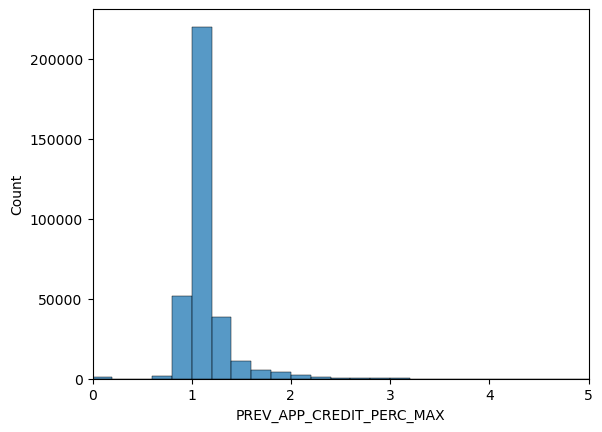

In [79]:
sns.histplot(data=df_total['PREV_APP_CREDIT_PERC_MAX'].replace([np.inf, -np.inf], np.nan),bins=100)
plt.xlim(0,5)


In [80]:
for col in df_total.loc[:,df_total.max(axis=0)==np.inf].columns:
    df_total[col] = df_total[col].replace([np.inf, -np.inf], np.nan)

In [81]:
df_total['PREV_APP_CREDIT_PERC_MAX'].describe()

count    338600.000000
mean          1.114310
std           0.312550
min           0.000000
25%           1.000000
50%           1.042350
75%           1.132024
max          20.000000
Name: PREV_APP_CREDIT_PERC_MAX, dtype: float64

### retrait des NaN

In [82]:
#retrait des na
df_total_sans_na=df_total.copy()
for col in df_total_sans_na.columns:
    df_total_sans_na[col]=df_total_sans_na[col].fillna(df_total_sans_na[col].mean())

In [83]:
df_total_sans_na[feat_important]

,EXT_SOURCE_2,PAYMENT_RATE,EXT_SOURCE_3,DAYS_BIRTH,DAYS_EMPLOYED,EXT_SOURCE_1,DAYS_EMPLOYED_PERC,DAYS_REGISTRATION,INDEX,DAYS_ID_PUBLISH,...,CLOSED_DAYS_CREDIT_VAR,CLOSED_AMT_CREDIT_SUM_MEAN,APPROVED_APP_CREDIT_PERC_VAR,AMT_CREDIT,POS_NAME_CONTRACT_STATUS_ACTIVE_MEAN,PREV_DAYS_DECISION_MAX,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_AMT_CREDIT_SUM_MEAN,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,ACTIVE_DAYS_CREDIT_VAR
ID,,,,,,,,,,,,,,,,,,,,,
100002,0.262949,0.060749,0.139376,-9461,-637.0,0.083037,0.067329,-3648.0,0,-2120,...,123956.700000,63844.500000,0.080044,406597.5,1.000000,-606.0,-499.875000,1.081319e+05,780.000000,440860.500000
100003,0.622246,0.027598,0.509353,-16765,-1188.0,0.311267,0.070862,-1186.0,1,-291,...,820590.333333,69133.500000,0.005324,1293502.5,0.928571,-746.0,-816.000000,2.543501e+05,1216.000000,302053.091847
100004,0.555912,0.050000,0.729567,-19046,-225.0,0.501964,0.011814,-4260.0,2,-2531,...,421362.000000,94518.900000,0.080044,135000.0,0.750000,-815.0,-532.000000,9.451890e+04,2521.752558,302053.091847
100006,0.650442,0.094941,0.509353,-19005,-3039.0,0.501964,0.159905,-9833.0,3,-2437,...,428717.936606,259089.261788,0.014849,312682.5,0.857143,-181.0,-542.967626,3.807409e+05,2521.752558,302053.091847
100007,0.322738,0.042623,0.509353,-19932,-3038.0,0.501964,0.152418,-4311.0,4,-3458,...,428717.936606,146250.000000,0.016456,513000.0,0.939394,-374.0,-783.000000,1.462500e+05,2521.752558,302053.091847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456221,0.648575,0.042354,0.643026,-19970,-5169.0,0.501964,0.258838,-9094.0,48739,-3399,...,477960.333333,93622.500000,0.080044,412560.0,0.750000,-683.0,-282.200000,2.237598e+05,644.000000,44402.000000
456222,0.684596,0.051267,0.509353,-11186,-1149.0,0.501964,0.102718,-3015.0,48740,-3003,...,428717.936606,259089.261788,0.009809,622413.0,0.945946,-770.0,-542.967626,3.807409e+05,2521.752558,302053.091847
456223,0.632770,0.105414,0.283712,-15922,-3037.0,0.733503,0.190742,-2681.0,48741,-1504,...,153749.666667,526440.375000,0.006176,315000.0,0.935484,-84.0,-308.400000,4.312619e+05,2521.752558,302053.091847


### calcul du skew pour passage au log

In [87]:
# version simplifiée du df de contrôle: donnée de type, Skew de la série et valeurs du describe
def Skew_df(x):
    # DataFrame de contrôles sur les colonnes
    tempo = pd.DataFrame(columns=['type','skew'])

    tot = x.shape[0]

    tempo['nomcol'] = pd.Series(x.columns) # nom des colonnes

    for i in x.columns:
        j=list(x.columns).index(i)
        tempo.at[j, 'type'] = x.dtypes[i]
        #tempo.at[j, '90%'] = np.percentile(x,95)
       
    
    temp=x.describe().T.copy()                  # describe des données numériques (min, max...)
    temp.drop(['count','std'],axis=1,inplace=True)                         # nombre et ecart-type pas ntéressants donc droppés
    tempo=tempo.merge(temp,how='left',left_on='nomcol',right_index=True)        # ajout des données numériques aux données de remplissage
        
        
    for i in tempo.loc[(tempo['type']!='category') & (tempo['type']!='object')]['nomcol']:                            #skew des données numériques
        tempo.at[tempo.loc[tempo['nomcol']==i].index.values[0],'skew']=x[i].skew()
    
    return tempo

In [88]:
df_total_skew=Skew_df(df_total)

In [151]:
# Calcul du percentile à 99% pour isoler les distributions avec un petit nombre de valeurs max très différentes du reste
df_total_skew.loc[df_total_skew['type']!=bool,'99_5%']=df_total_skew.loc[df_total_skew['type']!=bool]['nomcol'].apply(lambda x:np.percentile(df_total.loc[df_total[x].isna()==False,x],99.5)).values

In [152]:
df_total_skew

,type,skew,nomcol,mean,min,25%,50%,75%,max,test,99%,99_5%
0,int64,0.201311,INDEX,136052.869904,0.0,44532.0,129384.0,218447.5,307510.0,303947.5,303947.5,305728.75
1,int64,-0.000011,SK_ID_CURR,278128.870078,100001.0,189065.5,278129.0,367192.5,456255.0,452692.5,452692.5,454473.75
2,float64,3.078133,TARGET,0.080730,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.00
3,int64,-0.675528,CODE_GENDER,0.660001,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.00
4,int64,0.676941,FLAG_OWN_CAR,0.339699,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...
793,bool,-0.921919,CC_NAME_CONTRACT_STATUS_NAN_MAX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
794,float64,0,CC_NAME_CONTRACT_STATUS_NAN_MEAN,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
795,float64,0,CC_NAME_CONTRACT_STATUS_NAN_SUM,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
796,float64,0,CC_NAME_CONTRACT_STATUS_NAN_VAR,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00


In [153]:
# obtention des colonnes avec valeurs entre 0 et 1 => pas besoin de standard scale
df_total_skew.loc[ (df_total_skew['max']==1)]


,type,skew,nomcol,mean,min,25%,50%,75%,max,test,99%,99_5%
2,float64,3.078133,TARGET,0.080730,0.0,0.0,0.0,0.0,1.0,1.000000,1.000000,1.000000
3,int64,-0.675528,CODE_GENDER,0.660001,0.0,0.0,1.0,1.0,1.0,1.000000,1.000000,1.000000
4,int64,0.676941,FLAG_OWN_CAR,0.339699,0.0,0.0,0.0,1.0,1.0,1.000000,1.000000,1.000000
5,int64,0.838064,FLAG_OWN_REALTY,0.306764,0.0,0.0,0.0,1.0,1.0,1.000000,1.000000,1.000000
17,int64,-422.047391,FLAG_MOBIL,0.999994,0.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
769,float64,4.309648,CC_NAME_CONTRACT_STATUS_COMPLETED_MEAN,0.032644,0.0,0.0,0.0,0.0,1.0,0.571429,0.571429,0.714286
774,float64,77.022696,CC_NAME_CONTRACT_STATUS_DEMAND_MEAN,0.000143,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000
780,float64,78.030914,CC_NAME_CONTRACT_STATUS_REFUSED_SUM,0.000164,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000
785,float64,14.102418,CC_NAME_CONTRACT_STATUS_SENTPROPOSAL_SUM,0.004954,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000


In [154]:
serie_col_01=df_total_skew.loc[ (df_total_skew['max']==1),'nomcol']

In [157]:
df_total_skew.loc[(df_total_skew['max']>10) & (df_total_skew['max']>df_total_skew['99_5%']*2)]

,type,skew,nomcol,mean,min,25%,50%,75%,max,test,99%,99_5%
6,int64,2.026004,CNT_CHILDREN,0.414312,0.0,0.0,0.0,1.0,2.000000e+01,3.000000e+00,3.000000e+00,3.000000e+00
7,float64,403.647698,AMT_INCOME_TOTAL,170115.873094,25650.0,112500.0,153000.0,202500.0,1.170000e+08,4.860000e+05,4.860000e+05,6.300000e+05
8,float64,1.283241,AMT_CREDIT,587769.529030,45000.0,270000.0,500211.0,797557.5,4.050000e+06,1.858815e+06,1.858815e+06,2.013840e+06
9,float64,1.569705,AMT_ANNUITY,27425.644390,1615.5,16731.0,25078.5,34960.5,2.580255e+05,7.137000e+04,7.137000e+04,8.183700e+04
10,float64,1.394305,AMT_GOODS_PRICE,528021.190531,40500.0,234000.0,450000.0,675000.0,4.050000e+06,1.800000e+06,1.800000e+06,1.800000e+06
...,...,...,...,...,...,...,...,...,...,...,...,...
754,float64,106.088984,CC_SK_DPD_DEF_MEAN,0.151713,0.0,0.0,0.0,0.0,1.635685e+03,5.403635e-01,5.403635e-01,9.731259e-01
755,float64,107.525104,CC_SK_DPD_DEF_SUM,12.297766,0.0,0.0,0.0,0.0,1.504830e+05,2.500000e+01,2.500000e+01,3.900000e+01
756,float64,102.430508,CC_SK_DPD_DEF_VAR,66.276536,0.0,0.0,0.0,0.0,8.456734e+05,6.115335e+00,6.115335e+00,1.100000e+01
775,float64,77.611301,CC_NAME_CONTRACT_STATUS_DEMAND_SUM,0.013181,0.0,0.0,0.0,0.0,9.600000e+01,0.000000e+00,0.000000e+00,0.000000e+00


In [118]:
# obtention des colonnes avec skew fort + valeur max supérieure à 5x le quantile à 99%
df_total_skew.loc[(df_total_skew['skew']>10) & (df_total_skew['max']>10) & (df_total_skew['max']>df_total_skew['99%']*5)]

,type,skew,nomcol,mean,min,25%,50%,75%,max,test,99%
7,float64,403.647698,AMT_INCOME_TOTAL,170115.873094,25650.000000,112500.0,153000.00000,202500.0,1.170000e+08,486000.000000,486000.000000
79,float64,29.380984,OBS_30_CNT_SOCIAL_CIRCLE,1.425697,0.000000,0.0,0.00000,2.0,3.540000e+02,10.000000,10.000000
81,float64,29.273309,OBS_60_CNT_SOCIAL_CIRCLE,1.409436,0.000000,0.0,0.00000,2.0,3.510000e+02,10.000000,10.000000
108,float64,119.053212,AMT_REQ_CREDIT_BUREAU_QRT,0.304400,0.000000,0.0,0.00000,0.0,2.610000e+02,2.000000,2.000000
244,float64,207.20365,INCOME_CREDIT_PERC,0.411925,0.011801,0.2,0.31657,0.5,2.080033e+02,1.764706,1.764706
...,...,...,...,...,...,...,...,...,...,...,...
754,float64,106.088984,CC_SK_DPD_DEF_MEAN,0.151713,0.000000,0.0,0.00000,0.0,1.635685e+03,0.540363,0.540363
755,float64,107.525104,CC_SK_DPD_DEF_SUM,12.297766,0.000000,0.0,0.00000,0.0,1.504830e+05,25.000000,25.000000
756,float64,102.430508,CC_SK_DPD_DEF_VAR,66.276536,0.000000,0.0,0.00000,0.0,8.456734e+05,6.115335,6.115335
775,float64,77.611301,CC_NAME_CONTRACT_STATUS_DEMAND_SUM,0.013181,0.000000,0.0,0.00000,0.0,9.600000e+01,0.000000,0.000000


In [136]:
serie_col_skew_max=df_total_skew.loc[(df_total_skew['skew']>10)& (df_total_skew['max']>10) & (df_total_skew['max']>df_total_skew['99%']*5),'nomcol']

In [138]:
[i for i in serie_col_skew_max if i in serie_col_01]

[]

In [139]:
[i for i in serie_col_01 if i in serie_col_skew_max]

[]

In [147]:
df_total_skew.loc[(df_total_skew['nomcol'].isin(serie_col_01)==False) & (df_total_skew['nomcol'].isin(serie_col_skew_max)==False) & (abs(df_total_skew['skew'])>10) ,:]

,type,skew,nomcol,mean,min,25%,50%,75%,max,test,99%
104,float64,15.187888,AMT_REQ_CREDIT_BUREAU_HOUR,0.005809,0.0,0.0,0.0,0.0,4.000000,0.000000,0.000000
105,float64,28.30017,AMT_REQ_CREDIT_BUREAU_DAY,0.006282,0.0,0.0,0.0,0.0,9.000000,0.000000,0.000000
114,bool,33.321084,NAME_TYPE_SUITE_GROUPOFPEOPLE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115,bool,19.036582,NAME_TYPE_SUITE_OTHER_A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116,bool,13.298158,NAME_TYPE_SUITE_OTHER_B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
779,float64,78.675984,CC_NAME_CONTRACT_STATUS_REFUSED_MEAN,0.000002,0.0,0.0,0.0,0.0,0.013889,0.000000,0.000000
781,float64,78.412558,CC_NAME_CONTRACT_STATUS_REFUSED_VAR,0.000002,0.0,0.0,0.0,0.0,0.013889,0.000000,0.000000
784,float64,14.484536,CC_NAME_CONTRACT_STATUS_SENTPROPOSAL_MEAN,0.000059,0.0,0.0,0.0,0.0,0.024390,0.000000,0.000000
786,float64,14.435369,CC_NAME_CONTRACT_STATUS_SENTPROPOSAL_VAR,0.000060,0.0,0.0,0.0,0.0,0.024390,0.000000,0.000000


In [142]:
df_total_sans_na.head()

,INDEX,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_SIGNED_MAX,CC_NAME_CONTRACT_STATUS_SIGNED_MEAN,CC_NAME_CONTRACT_STATUS_SIGNED_SUM,CC_NAME_CONTRACT_STATUS_SIGNED_VAR,CC_NAME_CONTRACT_STATUS_NAN_MIN,CC_NAME_CONTRACT_STATUS_NAN_MAX,CC_NAME_CONTRACT_STATUS_NAN_MEAN,CC_NAME_CONTRACT_STATUS_NAN_SUM,CC_NAME_CONTRACT_STATUS_NAN_VAR,CC_COUNT
ID,,,,,,,,,,,,,,,,,,,,,
100002,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,True,0.003583,0.106781,0.002955,True,True,0.0,0.0,0.0,37.083683
100003,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,True,0.003583,0.106781,0.002955,True,True,0.0,0.0,0.0,37.083683
100004,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,True,0.003583,0.106781,0.002955,True,True,0.0,0.0,0.0,37.083683
100006,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,False,0.000000,0.000000,0.000000,False,False,0.0,0.0,0.0,6.000000
100007,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,True,0.003583,0.106781,0.002955,True,True,0.0,0.0,0.0,37.083683


In [ ]:
df_total_sans_na['CC_NAME_CONTRACT_STATUS_DEMAND_SUM'].describe()

count    356251.000000
mean          0.013181
std           0.524849
min           0.000000
25%           0.000000
50%           0.013181
75%           0.013181
max          96.000000
Name: CC_NAME_CONTRACT_STATUS_DEMAND_SUM, dtype: float64

### recherche d'une transfo des variables type CC_nAME_CONTRACT8STATUS_DEMAND_SUM

In [167]:
# skew élevé, valeur max différente en ordre de grandeurs de +de 99% du reste de la distribution

In [166]:
df_total_skew.loc[df_total_skew['nomcol']=='CC_NAME_CONTRACT_STATUS_DEMAND_SUM'],df_total_sans_na['CC_NAME_CONTRACT_STATUS_DEMAND_SUM'].sort_values(ascending=False)[:30]

(        type       skew                              nomcol      mean  min  \
 775  float64  77.611301  CC_NAME_CONTRACT_STATUS_DEMAND_SUM  0.013181  0.0   
 
      25%  50%  75%   max  test  99%  99_5%  
 775  0.0  0.0  0.0  96.0   0.0  0.0    0.0  ,
 ID
 172484    96.000000
 306464    93.000000
 431114    92.000000
 351706    87.000000
 144024    81.000000
 285265    79.000000
 375200    78.000000
 248384    74.000000
 346517    72.000000
 225791    71.000000
 236583    66.000000
 441297    63.000000
 280230    60.000000
 337884    55.000000
 250407    53.000000
 343365    52.000000
 282554    51.000000
 155492    51.000000
 172610    49.000000
 325299    40.000000
 347587     1.000000
 434321     1.000000
 296404     0.013181
 296397     0.013181
 296399     0.013181
 296400     0.013181
 402847     0.013181
 296363     0.013181
 296402     0.013181
 106881     0.013181
 Name: CC_NAME_CONTRACT_STATUS_DEMAND_SUM, dtype: float64)

In [175]:
df_temp=pd.DataFrame(data=range(0,1000),columns=['Int'])
df_temp['quantiles_1']=df_temp['Int'].apply(lambda x:np.percentile(df_total_sans_na['CC_NAME_CONTRACT_STATUS_DEMAND_SUM'],x/10))
df_temp['quantiles_2']=df_temp['Int'].apply(lambda x:np.percentile(df_total_sans_na['AMT_INCOME_TOTAL'],x/10))

In [176]:
df_temp

,Int,quantiles_1,quantiles_2
0,0,0.000000,25650.0
1,1,0.000000,31500.0
2,2,0.000000,36000.0
3,3,0.000000,40275.0
4,4,0.000000,40500.0
...,...,...,...
995,995,0.013181,630000.0
996,996,0.013181,675000.0
997,997,0.013181,675000.0
998,998,0.013181,765000.0


In [178]:
df_total_sans_na['AMT_INCOME_TOTAL'].sort_values()

ID
124157        25650.0
101965        25650.0
384810        26100.0
316377        26100.0
378118        26100.0
             ...     
252084      6750000.0
190160      9000000.0
385674     13500000.0
336147     18000090.0
114967    117000000.0
Name: AMT_INCOME_TOTAL, Length: 356251, dtype: float64

<Axes: ylabel='AMT_INCOME_TOTAL'>

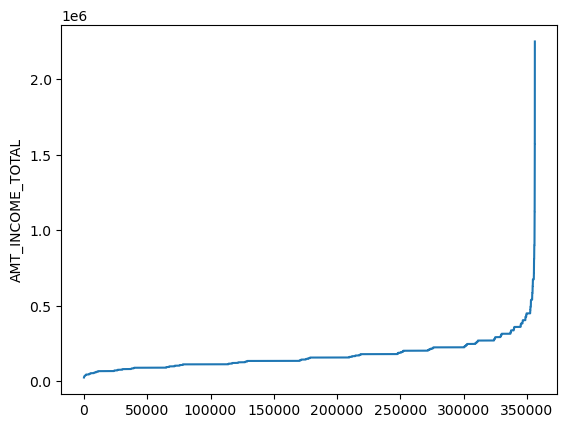

In [186]:
sns.lineplot(x=range(df_total_sans_na.shape[0]-30),y=df_total_sans_na['AMT_INCOME_TOTAL'].sort_values()[:-30])

<Axes: xlabel='Int', ylabel='quantiles_2'>

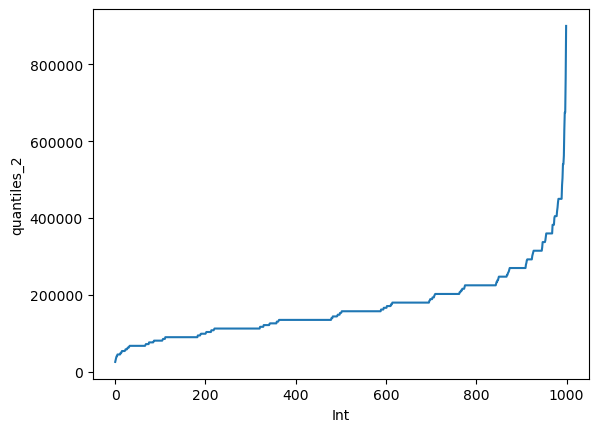

In [182]:
sns.lineplot(x=df_temp['Int'],y=df_temp['quantiles_2'])

In [ ]:
df_total_sans_na['CC_NAME_CONTRACT_STATUS_DEMAND_SUM'].sort_values(ascending=False)[:30]

ID
172484    96.000000
306464    93.000000
431114    92.000000
351706    87.000000
144024    81.000000
285265    79.000000
375200    78.000000
248384    74.000000
346517    72.000000
225791    71.000000
236583    66.000000
441297    63.000000
280230    60.000000
337884    55.000000
250407    53.000000
343365    52.000000
282554    51.000000
155492    51.000000
172610    49.000000
325299    40.000000
347587     1.000000
434321     1.000000
296404     0.013181
296397     0.013181
296399     0.013181
296400     0.013181
402847     0.013181
296363     0.013181
296402     0.013181
106881     0.013181
Name: CC_NAME_CONTRACT_STATUS_DEMAND_SUM, dtype: float64

## retrait des valeurs extrêmes : plafonds des variables au 99.5eme percentile

In [197]:
def plafonds_99_5(col):
    return col.clip(upper=np.percentile(col,99.5))
# 12 min
df_total_sans_na_2=df_total_sans_na.apply(plafonds_99_5,axis=)

type: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

In [196]:
plafonds_99_5(df_total_sans_na['OBS_30_CNT_SOCIAL_CIRCLE']).describe()

count    356251.000000
mean          1.407732
std           2.231058
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max          12.000000
Name: OBS_30_CNT_SOCIAL_CIRCLE, dtype: float64

In [194]:
df_total_sans_na_2['OBS_30_CNT_SOCIAL_CIRCLE'].describe()

count    356251.000000
mean          1.425697
std           2.596035
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max         354.000000
Name: OBS_30_CNT_SOCIAL_CIRCLE, dtype: float64

In [120]:
df_total_sans_na['OBS_30_CNT_SOCIAL_CIRCLE'].sort_values(ascending=False)

ID
386282    354.0
374163    353.0
392232    352.0
272071    348.0
189856     47.0
          ...  
279926      0.0
279927      0.0
279928      0.0
279929      0.0
456250      0.0
Name: OBS_30_CNT_SOCIAL_CIRCLE, Length: 356251, dtype: float64

In [123]:
# fonction transfo données centrées réduites
scaler = StandardScaler()

In [160]:
dt_total_scaled=pd.DataFrame(scaler.fit_transform(df_total_sans_na[['OBS_30_CNT_SOCIAL_CIRCLE','CC_NAME_CONTRACT_STATUS_DEMAND_SUM']]),
                                index=df_total_sans_na.index,
                                columns=['OBS_30_CNT_SOCIAL_CIRCLE','CC_NAME_CONTRACT_STATUS_DEMAND_SUM'])

In [163]:
dt_total_log_scaled=pd.DataFrame(scaler.fit_transform(np.log(df_total_sans_na[['OBS_30_CNT_SOCIAL_CIRCLE','CC_NAME_CONTRACT_STATUS_DEMAND_SUM']]+2)),
                                index=df_total_sans_na.index,
                                columns=['OBS_30_CNT_SOCIAL_CIRCLE','CC_NAME_CONTRACT_STATUS_DEMAND_SUM'])

In [162]:
dt_total_scaled.describe().round(4)

,OBS_30_CNT_SOCIAL_CIRCLE,CC_NAME_CONTRACT_STATUS_DEMAND_SUM
count,356251.0000,356251.0000
mean,-0.0000,-0.0000
std,1.0000,1.0000
min,-0.5492,-0.0251
25%,-0.5492,-0.0251
50%,-0.5492,0.0000
75%,0.2212,0.0000
max,135.8128,182.8848


In [164]:
dt_total_log_scaled.describe().round(4)

,OBS_30_CNT_SOCIAL_CIRCLE,CC_NAME_CONTRACT_STATUS_DEMAND_SUM
count,356251.0000,356251.0000
mean,-0.0000,-0.0000
std,1.0000,1.0000
min,-0.7703,-0.1823
25%,-0.7703,-0.1823
50%,-0.7703,0.0641
75%,0.6099,0.0641
max,9.5476,145.8136


In [ ]:

def visu_norm_vs_log(df, col):
    fig, axs = plt.subplots(ncols=2, figsize=(15,5))
    
    sns.histplot(df.loc[df[col]<=np.percentile(df[col],99)][col], bins=100,ax=axs[0],edgecolor='black')
    sns.histplot(np.log(df[col]+2), bins=100,ax=axs[1],edgecolor='black')

    plt.tight_layout()
    plt.show()
    
    

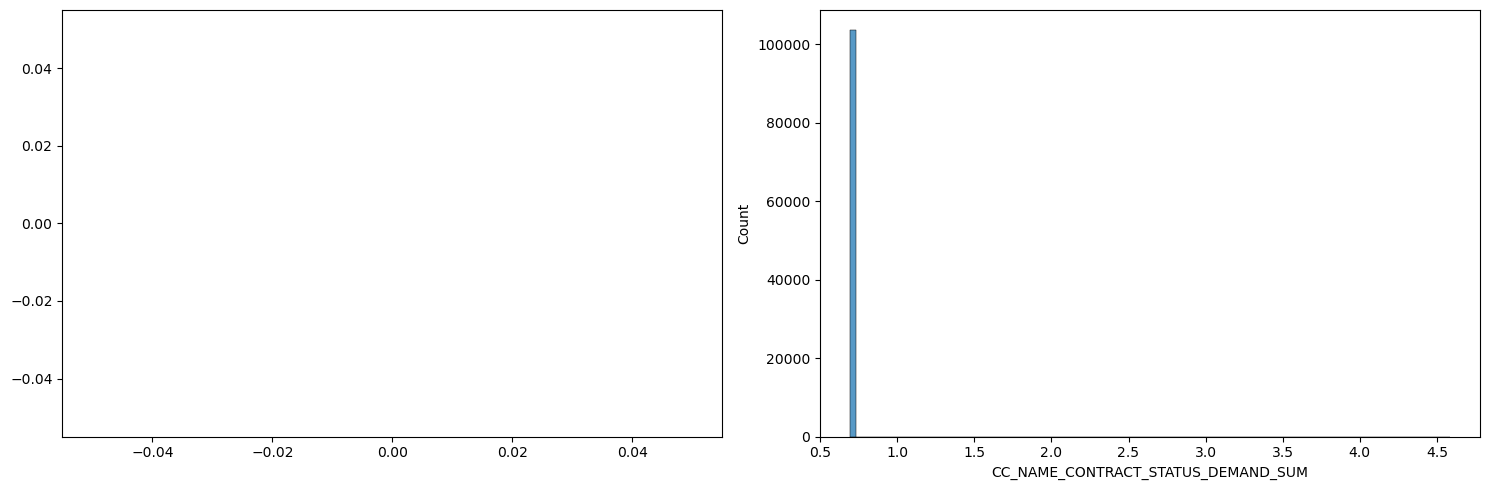

In [ ]:
visu_norm_vs_log(df_total, 'CC_NAME_CONTRACT_STATUS_DEMAND_SUM')

In [ ]:
df_total['CC_NAME_CONTRACT_STATUS_SENTPROPOSAL_SUM'].describe()

count    103558.000000
mean          0.004954
std           0.070209
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: CC_NAME_CONTRACT_STATUS_SENTPROPOSAL_SUM, dtype: float64

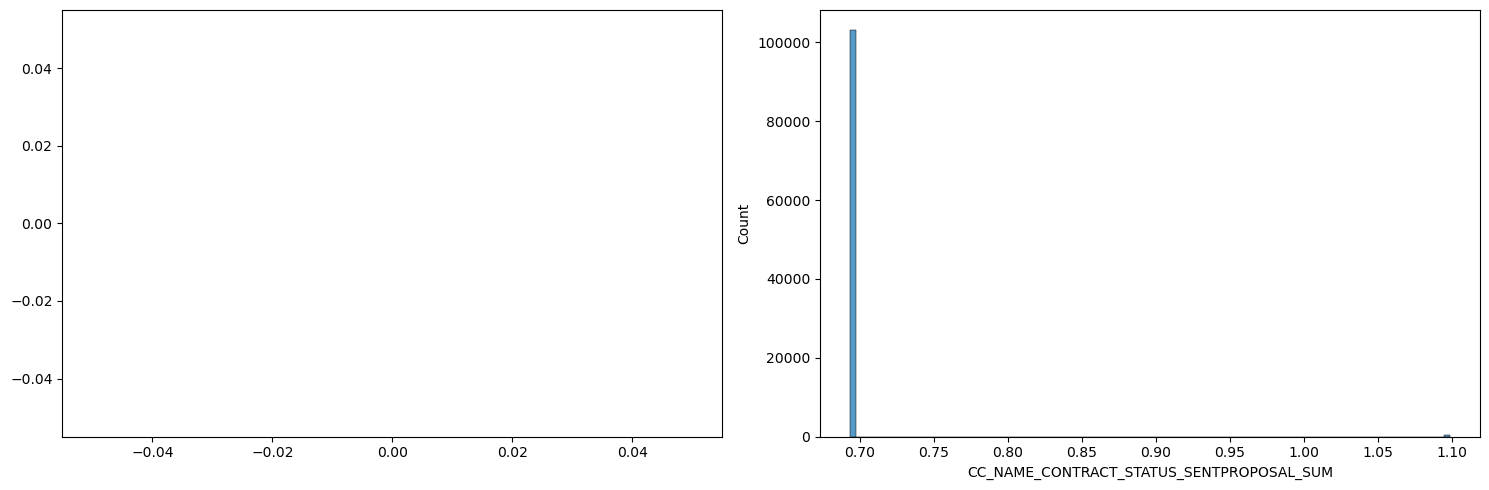

In [ ]:
visu_norm_vs_log(df_total, 'CC_NAME_CONTRACT_STATUS_SENTPROPOSAL_SUM')

# ACP sur données totales

In [ ]:
data_ACP=df_total_sans_na.copy()

Variance_ratio: [5.97796761e-01 2.41716297e-01 1.00913152e-01 2.50916244e-02
 1.80161833e-02 1.18474885e-02 2.69520961e-03 1.25645724e-03
 5.98646698e-04 5.40938722e-05 1.37807650e-05 1.12080139e-07
 7.06234275e-08 2.92130419e-08 2.39997102e-08 2.22804675e-08
 2.05262113e-08 6.12461122e-09 4.51284574e-09 4.14064993e-09
 3.29209650e-09 1.42754187e-09 1.15065932e-09 7.73733327e-10
 6.20939567e-10 5.86148695e-10 5.75044197e-10 4.98358559e-10
 4.78377439e-10 4.12515759e-10 2.51798270e-10 2.38172574e-10
 1.94489099e-10 1.92425215e-10 1.80404314e-10 1.64151420e-10
 1.46488269e-10 1.24309301e-10 1.19071293e-10 1.13559617e-10
 1.00789837e-10 7.99333859e-11 7.10828178e-11 6.80279312e-11
 6.43356274e-11 6.29455628e-11 4.60538181e-11 4.49744841e-11
 3.98415803e-11 3.49810673e-11 3.25113102e-11 3.17755581e-11
 2.49059580e-11 2.38978640e-11 1.64991258e-11 1.61621518e-11
 1.42306680e-11 1.38143822e-11 1.13019522e-11 7.40628911e-12
 6.39950628e-12 5.84685008e-12 5.56427688e-12 5.16482391e-12
 4.86509

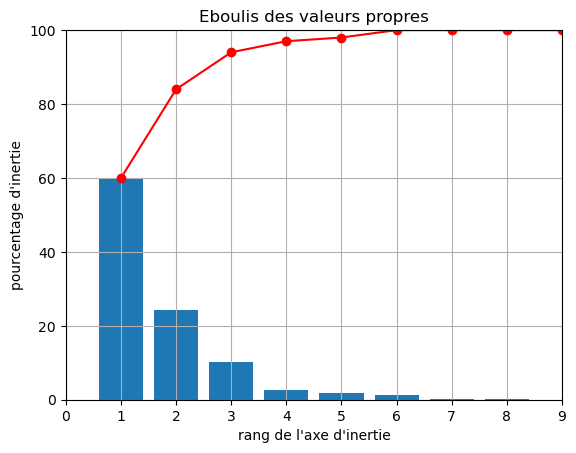

In [ ]:
n_components = 100
pca = PCA(n_components=n_components)
names = data_ACP.index
features = data_ACP.columns
pca.fit(data_ACP)
scree = (pca.explained_variance_ratio_*100).round(2)
scree_cum = scree.cumsum().round()
x_list = range(1, n_components+1)
print('Variance_ratio:', pca.explained_variance_ratio_, '\n',
      'Inerties:', scree, '\n',
      'Inerties_cumulées', scree_cum)
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum, c="red", marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.grid()
plt.ylim(0, 100)
plt.xlim(0, 9)
plt.show()

In [ ]:
pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
pcs.round(4)

,INDEX,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_SIGNED_MAX,CC_NAME_CONTRACT_STATUS_SIGNED_MEAN,CC_NAME_CONTRACT_STATUS_SIGNED_SUM,CC_NAME_CONTRACT_STATUS_SIGNED_VAR,CC_NAME_CONTRACT_STATUS_NAN_MIN,CC_NAME_CONTRACT_STATUS_NAN_MAX,CC_NAME_CONTRACT_STATUS_NAN_MEAN,CC_NAME_CONTRACT_STATUS_NAN_SUM,CC_NAME_CONTRACT_STATUS_NAN_VAR,CC_COUNT
F1,0.0000,-0.0000,0.0,-0.0,0.0,-0.0,0.0,0.0000,0.0000,0.0000,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0000
F2,-0.0000,-0.0000,-0.0,0.0,0.0,-0.0,-0.0,0.0000,0.0000,0.0000,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0000
F3,-0.0000,-0.0000,-0.0,-0.0,0.0,-0.0,0.0,0.0000,0.0000,0.0000,...,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0000
F4,-0.0000,-0.0000,-0.0,0.0,0.0,-0.0,-0.0,0.0000,0.0000,0.0000,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0000
F5,-0.0000,0.0000,-0.0,-0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,...,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F96,0.0077,-0.0064,-0.0,-0.0,0.0,-0.0,0.0,-0.0007,0.0045,0.0958,...,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0001
F97,-0.0044,0.0035,0.0,0.0,-0.0,0.0,-0.0,0.0006,-0.0039,-0.0449,...,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0000
F98,-0.0074,0.0057,-0.0,0.0,-0.0,0.0,-0.0,0.0005,-0.0008,-0.0904,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0001
F99,0.0007,-0.0006,0.0,-0.0,-0.0,0.0,-0.0,0.0013,-0.0038,0.0026,...,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0001


In [ ]:
def correlation_graph(pca,
                      x_y,
                      features):
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y
    x, y = x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante :
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0, 0,
                 pca.components_[x, i],
                 pca.components_[y, i],
                 head_width=0.07,
                 head_length=0.07,
                 width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                 pca.components_[y, i] + 0.05,
                 features[i])

    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')
    plt.grid()

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(
        x+1, round(100*pca.explained_variance_ratio_[x], 1)))
    plt.ylabel('F{} ({}%)'.format(
        y+1, round(100*pca.explained_variance_ratio_[y], 1)))

    # Titre
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

count    356251.000000
mean          0.509353
std           0.174136
min           0.000527
25%           0.413597
50%           0.509353
75%           0.634706
max           0.896010
Name: EXT_SOURCE_3, dtype: float64

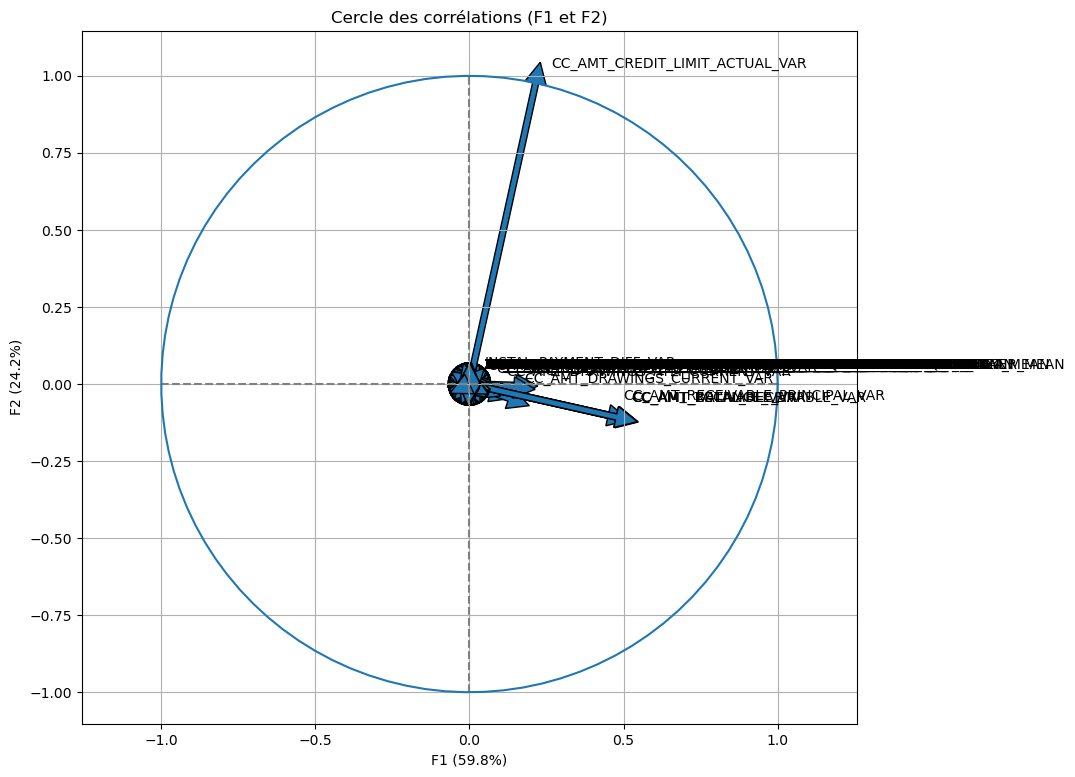

In [ ]:
correlation_graph(pca, (0, 1), features)

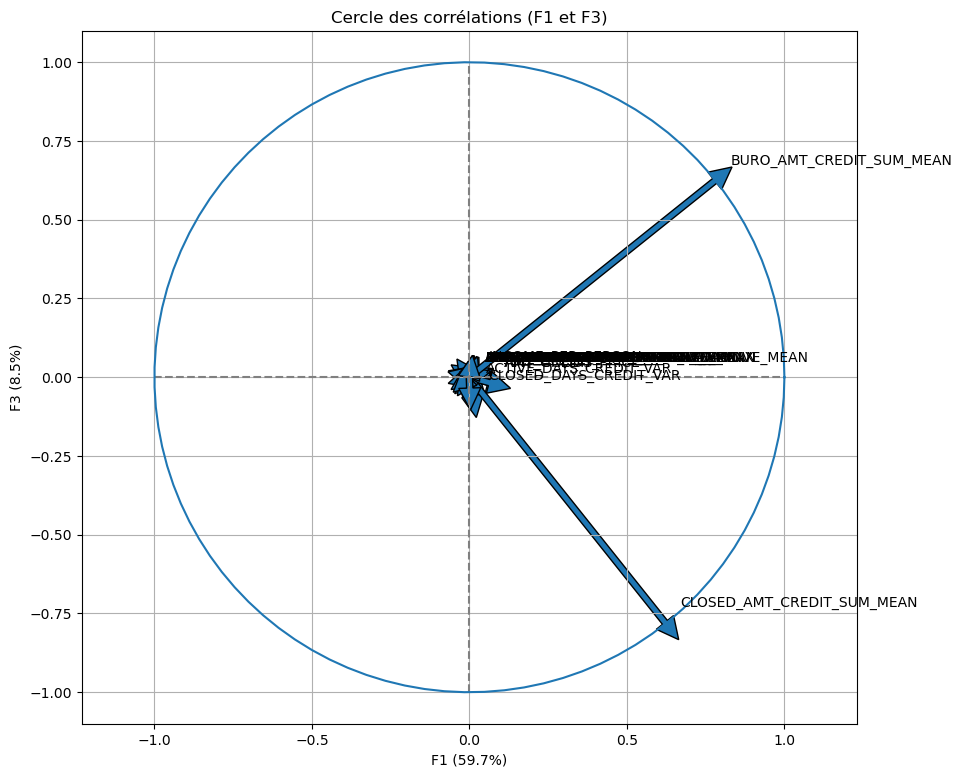

In [ ]:
correlation_graph(pca, (0, 2), features)

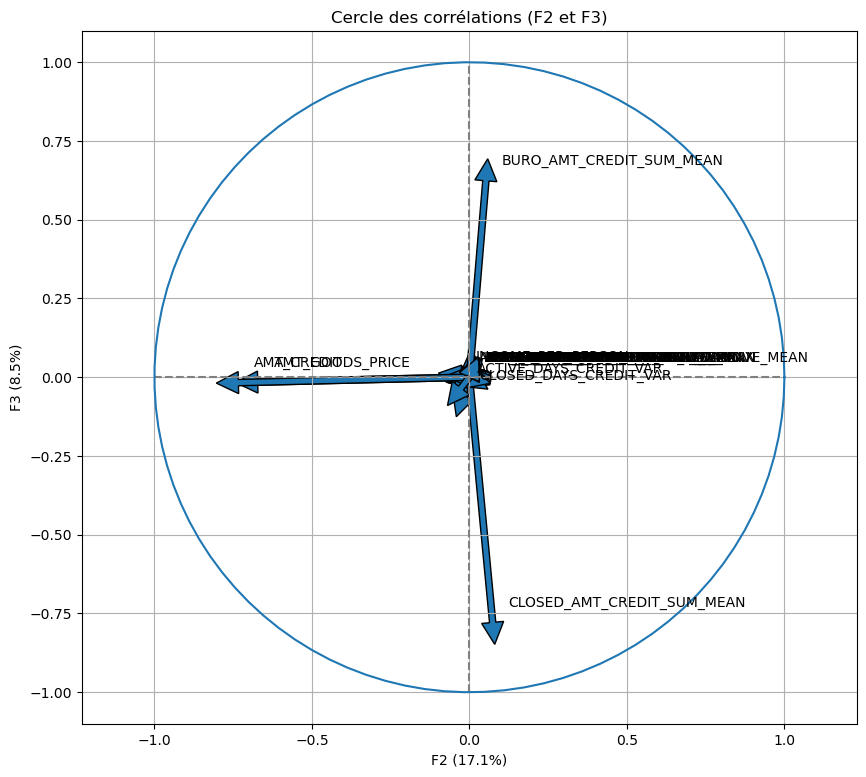

In [ ]:
correlation_graph(pca, (1, 2), features)

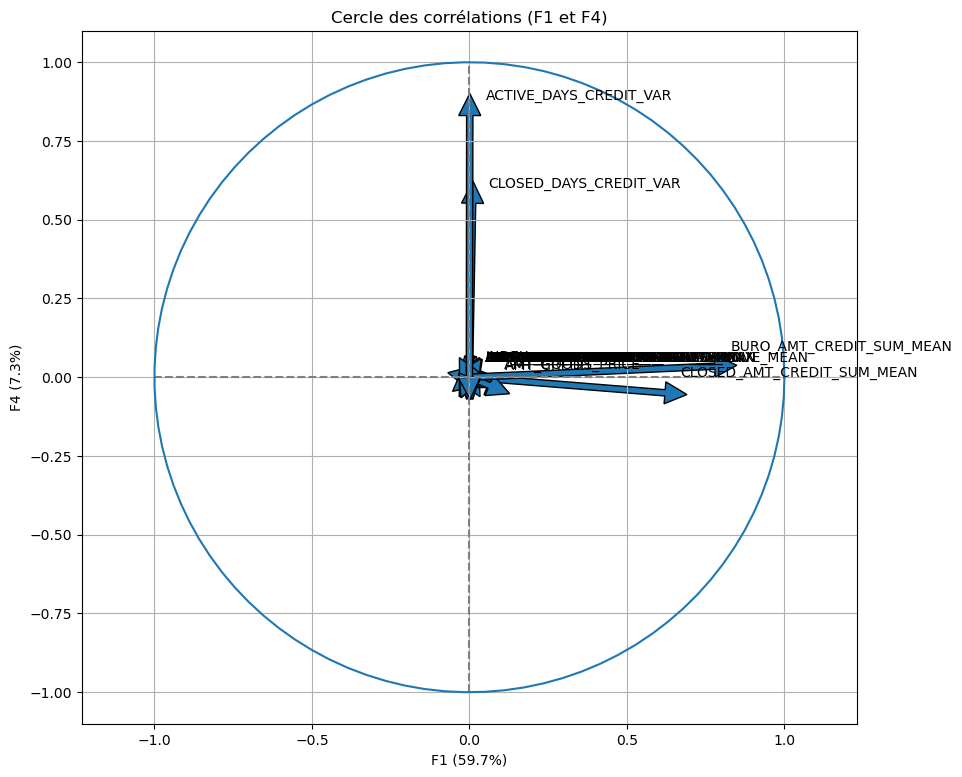

In [ ]:
correlation_graph(pca, (0, 3), features)